<a href="https://colab.research.google.com/github/Emadkadro/MMU_Year2_ML_ClassificationANDRegressionModels_FromScratch/blob/main/1CWK50_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change current working directory
import os
os.chdir('/content/drive/MyDrive/ML/Assignment/1CWK50-ML/')

In [ ]:
# check we can see the datasets

# datasets that are useful for testing classifiers
os.path.isfile('iris.csv')
os.path.isfile('moons.csv')
os.path.isfile('biopsies.csv')

# datasets that are useful for testing regressors
os.path.isfile('sepal_regression.csv')
os.path.isfile('iris_regression.csv')
os.path.isfile('concrete.csv')

True

#### Quick overview
**The aim of this project:** This project focuses on implementing predictive modelling across diverse datasets, including Moons, Iris, and Biopsies. It evaluates the model performance by comparing the accuracy results of the model on each dataset, demonstrating the model's strengths, limitations, and practical applications in classification or regression tasks for both synthetic and real-world data scenarios.

My implementation
This section includes a class that implements a classifier predictive model. It will be a class with a summary code comment at the top, explaining how the model works, a constructor (which might support some hyperparameters), a `fit()` method, a `predict_one()` method and a `predict()` method. The code inside the class will be appropriately commented.



## Loaded packages

In [ ]:
# Import the packages we use
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import norm
# Ensemble Classifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# KNN Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# NB Model
from sklearn.naive_bayes import GaussianNB

# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

# Ensemble Model
from sklearn.model_selection import train_test_split

# Voting Model
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc

# bagging Model
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report
from copy import deepcopy

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder



##**MY CLASSIFICATION MODELS CLASSES**

### **My Decision Tree Classifier**

In [ ]:
class Node:
    # Initialise The Node class
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, class_counts=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.class_counts = class_counts  # Store class counts for probability predictions

    # Check if Leaf Node means the final prediction for a subset of the data (the node at the stop condition).
    def is_leaf_node(self):
        return self.value is not None


class MyDecisionTreeClassifier:
    # Initialise the Decision Tree Regressor
    # Setting the hyperparameter max_depth helps with controlling the stopping condition, preventing overfitting.
    # min_samples_split Sets the minimum number of internal node splits.
    def __init__(self, max_depth=100, min_samples_split=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.root = None
        self.label_map = None  # To map class labels to integers for consistent processing
        self.inverse_label_map = None  # To map integers back to original labels


    # Training the DT Regressor using the train examples/labels
    def fit(self, train_examples, train_labels):
       # Map labels to integers for consistent processing
        label_map = {label: idx for idx, label in enumerate(np.unique(train_labels))}
        self.label_map = label_map
        #  Integer labels back to their original values during predictions.
        self.inverse_label_map = {v: k for k, v in label_map.items()}
        train_labels = np.array([label_map[label] for label in train_labels])

        # Set n_features to all features if not specified
        self.n_features = train_examples.shape[1] if self.n_features is None else min(train_examples.shape[1], self.n_features)
        # Build the tree starting from the root recursively.
        self.root = self.grow_tree(train_examples, train_labels)



    # Building the SubTree using grow_tree function based on the data
    def grow_tree(self, examples, labels, depth=0):  # Depth=1 unless we create a new child node
        # Getting the number of samples and features of the training data
        n_samples, n_feats = examples.shape
        n_unique_labels = len(np.unique(labels))

        # Check the stopping conditions (n_lab==1 means is a leaf node)
        if depth >= self.max_depth or n_unique_labels == 1 or n_samples < self.min_samples_split:
            # Create a new Node and return it
            leaf_value = self.most_common_label(labels)  # Helper function 1 below to find most common
            # creates and returns a new instance of the Node class, representing a leaf node in the decision tree.
            return Node(value=leaf_value, class_counts=dict(Counter(labels)))

        # Create random feature selection to the tree considering the n_feature
        # Avoid duplication feature (total n_features we have, n_features we want to select, without replacement)
        feat_idx = np.random.choice(n_feats, self.n_features, replace=False)

        # Find the best split
        best_feature, best_thresh = self.best_split(examples, labels, feat_idx)  # Helper Function 3

        # If no valid split, return a leaf node
        if best_feature is None or best_thresh is None:
            leaf_value = self.most_common_label(labels)
            # creates and returns a new instance of the Node class, representing a leaf node in the decision tree.
            return Node(value=leaf_value, class_counts=dict(Counter(labels)))


        # Recursively create Child Node to grow the tree
        left_indices, right_indices = self.split(examples[:, best_feature], best_thresh)  # rotate best on best split
        left = self.grow_tree(examples[left_indices, :], labels[left_indices], depth + 1)  # increase the depth by 1
        right = self.grow_tree(examples[right_indices, :], labels[right_indices], depth + 1)
        return Node(best_feature, best_thresh, left, right)  # Return the new node with the best Fea and Thresh ...

    #Traverse the tree for each test example to find the predicted class.
    def predict(self, test_examples):
        # Create a list of traverse tree nodes based on the traverse_tree predict label
        predictions = [self.traverse_tree(example, self.root) for example in test_examples]
        return [self.inverse_label_map[pred] for pred in predictions]  # Map back to original labels


    def predict_proba(self, test_examples):
        # Compute probabilities for each example
        probabilities = []  # Initialise an empty list to store the probability distributions for each test example

        # Iterate over each example in the test data
        for example in test_examples:
            node = self.root  # Start traversing from the root node of the decision tree

            # Traverse the tree until a leaf node is reached
            while not node.is_leaf_node():
                # If the Node feature for this example is <= the threshold, predict left
                if example[node.feature] <= node.threshold:
                    node = node.left  # Move to the left child node
                else:
                    node = node.right  # Move to the right child node

            # Return the class counts from the leaf node
            class_counts = node.class_counts  # This is a dictionary containing the class counts in the leaf node

            # Total number of examples in this leaf node by calculating the class counts
            total = sum(class_counts.values())

            # Calclate the probability for each class in the leaf node
            # For each class, divide its count by the total number of examples in this node
            # Append the probability distribution as a dictionary to the probabilities list
            probabilities.append(
                [class_counts.get(cls, 0) / total for cls in range(len(self.label_map))]
            )

        return np.array(probabilities)  # Return a 2D NumPy array
    # Helper Function 4
    # ----------------------------------------------------------------------------------------------------------
    def traverse_tree(self, example, node):  # passing the starting node
        if node.is_leaf_node():  # Check if leaf Node
            return node.value
        # If the node value <= threshold value pass the left side of the tree to be traversed next. Else traverse right
        if example[node.feature] <= node.threshold:
            return self.traverse_tree(example, node.left)
        return self.traverse_tree(example, node.right)

    # Helper Function 3
    # ----------------------------------------------------------------------------------------------------------
    # Creating Child Node Function based on the best split value
    def best_split(self, examples, labels, feat_idx):
        # Variables needed
        best_gain = -1
        split_idx = None
        split_threshold = None

        # Traverse all possible options
        for feat in feat_idx:
            feature_values = examples[:, feat]
            thresholds = np.unique(feature_values)  # thresholds = all possible

            # Calculate the info gain
            for thresh in thresholds:
                gain = self.information_gain(labels, feature_values, thresh)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat
                    split_threshold = thresh

        # Find the Threshold among all the thresholds available
        return split_idx, split_threshold

    # Helper Functions 2
    # ---------------------------------------------------------------------------------------------------------------
    # Information Gain (Best Split Function)
    def information_gain(self, labels, feature_values, threshold):
        # Parent entropy
        parent_entropy = self.entropy(labels)  # helper function below

        # Create children
        left_indices, right_indices = self.split(feature_values, threshold)
        if len(left_indices) == 0 or len(right_indices) == 0:  # Handle if indices = 0
            return 0

        # Calculate weighted average of entropy of children
        n = len(labels)  # number of samples in labels
        n_left, n_right = len(left_indices), len(right_indices)  # number of samples on the left and right
        e_left, e_right = self.entropy(labels[left_indices]), self.entropy(labels[right_indices])  # entropy of the l & r
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right
        return parent_entropy - child_entropy

    # Helper Function Calculating the Create children (Split)
    def split(self, feature_values, threshold):
        left_indices = np.argwhere(feature_values <= threshold).flatten()  # Indices rotate left
        right_indices = np.argwhere(feature_values > threshold).flatten()  # Indices rotate right
        return left_indices, right_indices

    # Helper function calculating (entropy)
    def entropy(self, labels):
        hist = np.bincount(labels)
        ps = hist / len(labels)  # calculating the p of x based on the role
        return -np.sum([p * np.log(p) for p in ps if p > 0])  # Final result based on the role

    # -----------------------------------------------------------------------------------------------------------
    # Helper Functions 1

    # Calculating the Common Label to be assigned to the leaf_value (Stop Function)
    def most_common_label(self, labels):
        counter = Counter(labels)  # Create the counter of my most common label value
        value = counter.most_common(1)[0][0]  # (MostCommon1), [Common Tuple], [First info includes the value]
        return value


### **My Naive Bayes Classifier**

In [ ]:
class MyNaiveBayesClassifier:

    def fit(self, train_examples, train_labels):
        n_samples, n_features = train_examples.shape # Get number of Feature, samples
        self.unique_classes = np.unique(train_labels)   # Get unique classes
        n_classes = len(self.unique_classes)            # Get number of Classes


        # Initialise the mean, variances, and prior for each class
        self.means = np.zeros((n_classes, n_features), dtype=np.float64)    # set means at zero for now
        self.variances = np.zeros((n_classes, n_features), dtype=np.float64) # set variances at zero for now
        self.priors = np.zeros((n_classes), dtype=np.float64) # set priors at zero for now for each class only

        # Start the calculation for each unique class
        for index, cls in enumerate(self.unique_classes):
            # Get the examples of the class
            cls_examples = train_examples[train_labels == cls]

            # Calculate and store priors, means, and variances for each feature
            self.means[index, :] = np.mean(cls_examples, axis=0) # Mean of features for this class
            self.variances[index, :] = np.var(cls_examples, axis=0) # Variance of features for this class
            self.priors[index] =  cls_examples.shape[0] / float(n_samples) # Prior for the classnumber of samples/total samples


    def predict_proba(self, test_examples):
        # Compute probabilities for each class given the test examples.
        probabilities = []
        for example in test_examples: # For each example
            class_probs = []          # Store class probability

            for index, cls in enumerate(self.unique_classes):
                prior = self.priors[index]

                # Calculate likelihood using Gaussian distribution
                mean = self.means[index]
                variance = self.variances[index]
                # Calculate likelihood for each feature
                likelihood = np.prod((1 / np.sqrt(2 * np.pi * variance))
                                      * np.exp(-((example - mean) ** 2) / (2 * variance)))

                # Combine prior and likelihood
                class_probs.append(prior * likelihood)

            # Normalise probabilities
            total_prob = sum(class_probs)
            class_probs = [prob / total_prob for prob in class_probs]
            probabilities.append(class_probs)

        return np.array(probabilities)

    def predict(self, test_examples):
        # Predict the class with the highest probability.
        probabilities = self.predict_proba(test_examples)
        return [self.unique_classes[np.argmax(prob)] for prob in probabilities]

### **My K-Nearest Neighbors Classifier**

In [ ]:


 # Helper Function Create a global function to calculate the distances between nodes
def euclidean_distance(x1, x2): # x reperesent an array
    distance = np.sqrt(np.sum((x1-x2)**2))
    return distance
#-----------------------------------------------------------------------------------------------------


class MyKnnClassifier:
    def __init__(self, k=1):
        self.k = k

    def fit(self, train_examples, train_labels):
        self.train_examples = train_examples
        self.train_labels = train_labels
        self.unique_classes = np.unique(train_labels)  # Identify all unique classes

    def predict_one(self, test_example):
        # Calculate the distances between the test example and each training example
        distances = [euclidean_distance(test_example, train_example) for train_example in self.train_examples]
        # Get the indices of the k-nearest training examples (sorted by distance)
        k_nearest_indices = np.argsort(distances)[:self.k]
        # Get the labels of the k-nearest neighbors
        k_nearest_labels = [self.train_labels[i] for i in k_nearest_indices]
        # Majority vote: return the most common label (just the label, not the count)
        most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]  # Extract only the most common label
        return most_common_label

    def predict(self, test_examples):
      # Calculate the prediction for all
        predictions = [self.predict_one(test_example) for test_example in test_examples]
        return predictions

    def predict_proba(self, test_examples):
        # Calculate probabilities for each class based on the k-nearest neighbors.
        probabilities = [] # Initialise an empty list to store probability

          # Iterate over each test example
        for test_example in test_examples:

            # Calculate the Euclidean distance between the test example and each training example
            distances = [np.linalg.norm(test_example - train_example) for train_example in self.train_examples]

            # Get the indices of the k-nearest training examples (sorted by distance)
            nearest_indices = np.argsort(distances)[:self.k]

            # Retrieve the labels of the k-nearest neighbors based on the nearest indices
            k_nearest_labels = [self.train_labels[i] for i in nearest_indices]

            # Count the occurrences of each class label among the k-nearest neighbors
            class_counts = {cls: 0 for cls in self.unique_classes}  # Initialize a dictionary with classes as keys and counts as values
            for label in k_nearest_labels:
                class_counts[label] += 1  # Increment the count for the class label

            # Calculate the probability for each class by dividing the count of the class
            # by the total number of nearest neighbors (which is k)
            total_neighbors = len(k_nearest_labels)
            probabilities.append([class_counts[cls] / total_neighbors for cls in self.unique_classes])

        # Return the probabilities as a NumPy array (each row corresponds to the probability distribution for a test example)
        return np.array(probabilities)

### **My Ensemble Classifier**

In [ ]:
# The EnsembleClassifier combines multiple models to improve performance.
class MyEnsembleClassifier:
    def __init__(self, base_models, voting="hard", feature_sampling=False):
        self.base_models = base_models  # Models to combine holder
        self.voting = voting  # Voting type: "will be assigned" (majority voting) or "soft" (probability averaging).
        self.feature_sampling = feature_sampling  # Whether to use random feature subsets
        self.feature_subsets = []  # To store feature subsets for each model
        self.label_map = None  # Maps class labels to integers
        self.inverse_label_map = None  # Reverse mapping for predictions


    def fit(self, train_examples, train_labels):
        # Reset feature subsets for this training cycle
        self.feature_subsets = []

        # Map labels Convert string into integers for consistency
        self.label_map = {label: idx for idx, label in enumerate(np.unique(train_labels))} # Assign numerical label to train_labels (0,1)
        train_labels = np.array([self.label_map[label] for label in train_labels]) # Create an array of these numerical label
        self.inverse_label_map = {v: k for k, v in self.label_map.items()} # Convert Predicted label back to string

        for model in self.base_models: # For each model in my models list
            if self.feature_sampling:
              # If Each model is trained randomly select a subset of features for the model
                n_features = train_examples.shape[1] #Get the number of columns
                # Create random selection of feature
                feature_indices = np.random.choice(n_features, size=int(np.sqrt(n_features)), replace=False)

                self.feature_subsets.append(feature_indices)  # Store selected random features
                train_subset = train_examples[:, feature_indices]  # Use subset for training
                model.fit(train_subset, train_labels)  # Train model on selected random features
            else:
                model.fit(train_examples, train_labels)  # Train model on all features


    # Create predict_proba for soft voting
    def predict_proba(self, test_examples):
        # Ensure all models support probability prediction for soft voting
        if not all(hasattr(model, "predict_proba") for model in self.base_models): # Handel error
            raise AttributeError("All base models must implement 'predict_proba' for soft voting.") #return message

        # Predict the probabilities for the models []
        probabilities = [
            # Use feature subset for models trained with feature sampling

            # select the feature subset corresponding to the model
            model.predict_proba(test_examples[:, self.feature_subsets[idx]])
            if self.feature_sampling
            else model.predict_proba(test_examples) # Use the all features
            for idx, model in enumerate(self.base_models) # Repeat for all models idx
        ]
        # Average probabilities across all models
        avg_probabilities = np.mean(probabilities, axis=0)
        return avg_probabilities

    def predict(self, test_examples):
        if self.voting == "hard":
            # Collect predictions from all models
            predictions = [
                # If feature_sampling, select the feature subset corresponding to the model
                model.predict(test_examples[:, self.feature_subsets[idx]])
                if self.feature_sampling
                else model.predict(test_examples) # Use the all features
                for idx, model in enumerate(self.base_models) # Repeat for all models idx
            ]
            predictions = np.array(predictions).T  # Organise predictions per example

            # Use majority voting to determine final predictions using np.bincount().argmax().
            final_predictions = [
                np.bincount(prediction_row).argmax() for prediction_row in predictions
            ]

        elif self.voting == "soft":
            # Aggregate probabilities from all models
            probabilities = [
                model.predict_proba(test_examples[:, self.feature_subsets[idx]])
                if self.feature_sampling
                else model.predict_proba(test_examples)
                for idx, model in enumerate(self.base_models)
            ]
            probabilities = np.mean(probabilities, axis=0)  # Average probabilities
            final_predictions = np.argmax(probabilities, axis=1)  # Choose class with highest probability
        else:
            raise ValueError("Invalid voting type. Use 'hard' or 'soft'.")

        # Convert numeric predictions back to original labels
        return np.array([self.inverse_label_map[pred] for pred in final_predictions])

### **My Bagging Classifier**

In [ ]:
class myBaggingClassifier:
    def __init__(self, base_model, n_estimators=10, bootstrap=True, bootstrap_features=False):
        self.base_model = base_model  # The base model to be used (e.g., decision tree)
        self.n_estimators = n_estimators  # Number of models in the ensemble
        self.bootstrap = bootstrap  # Whether to sample data with replacement
        self.bootstrap_features = bootstrap_features  # Whether to sample features
        self.models = []  # To store trained models
        self.feature_indices = []  # To store feature subsets for each model

    def fit(self, train_examples, train_labels):
        self.models = []  # Reset models for new training
        self.feature_indices = []  # Reset feature subsets
        n_samples, n_features = train_examples.shape

        for _ in range(self.n_estimators):
            # Sample data indices for bootstrapping
            indices = np.random.choice(n_samples, size=n_samples, replace=self.bootstrap)
            bootstrap_samples = train_examples[indices]
            bootstrap_labels = train_labels[indices]

            # Sample features if bootstrap_features is enabled
            if self.bootstrap_features:
                feature_indices = np.random.choice(n_features, size=n_features, replace=self.bootstrap_features)
                bootstrap_samples = bootstrap_samples[:, feature_indices]  # Use selected features
                self.feature_indices.append(feature_indices)  # Save feature subset
            else:
                self.feature_indices.append(None)  # Use all features

            # Create and train a deep copy of the base model
            model = deepcopy(self.base_model)
            model.fit(bootstrap_samples, bootstrap_labels)
            self.models.append(model)  # Store the trained model

    def predict(self, test_examples):
        # Collect predictions from all models
        aggregated_predictions = []
        for i, model in enumerate(self.models):
            # Use feature subset if bootstrap_features was applied
            if self.feature_indices[i] is not None:
                predictions = model.predict(test_examples[:, self.feature_indices[i]])
            else:
                predictions = model.predict(test_examples)
            aggregated_predictions.append(predictions)  # Collect predictions

        # Use majority voting to determine final predictions
        aggregated_predictions = np.array(aggregated_predictions).T  # Arrange predictions per example
        final_predictions = [Counter(row).most_common(1)[0][0] for row in aggregated_predictions]
        return np.array(final_predictions)

### **My Random Forest Classifier**

In [ ]:
class MyRandomForestClassifier:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, n_features=None):
        self.n_trees = n_trees  # Number of decision trees in the forest
        self.max_depth = max_depth  # Maximum depth for each tree
        self.min_samples_split = min_samples_split # Minimum samples required to split a node
        self.n_features = n_features  # to get the number of feature when it needed
        self.trees = []  # To store the decision trees in an empty array


    # Create the Forest with different types of trees trained on different training data
    def fit(self, train_examples, train_labels):
      self.trees = []  # an araay to hold the tree values
      for _ in range(self.n_trees): #Create trees as the number of n_trees
         # Create a tree using the DT classifier with the parameters initialised above
          tree = MyDecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples_split, n_features=self.n_features)

          # Random selection of samples with replacement using boostrap_samples()
          sampled_examples, sampled_labels = self.boostrap_samples(train_examples, train_labels)
          # Pass the sampled training data into the fit()
          tree.fit(sampled_examples, sampled_labels)
          self.trees.append(tree)  # Add the trained tree to the forest

    def predict_one(self, example):
       # Get predictions from all trees for a single example
         prediction_for_example = np.array([tree.predict([example])[0] for tree in self.trees])
          # Get the most common occurrence label using the Helper Function 2
         most_common_pred = self.most_common_label(prediction_for_example)
         return most_common_pred #return predected label

    def predict(self, test_examples):
        # Predict for each example in the test set
        tree_predictions = np.array([self.predict_one(example) for example in test_examples])
        return tree_predictions




    # Helper Function 2
    #-----------------------------------------------------------------------------------------------
    # Calculating the Common Label to be assigned to the leaf_value (Stop Function)
    def most_common_label(self, train_labels):
        counter = Counter(train_labels)  # Create the counter of my most common label value
        value = counter.most_common(1)[0][0]  # (MostCommon1), [Common Tuple], [First info includes the value]
        return value


    # Helper Function 1
    #-----------------------------------------------------------------------------------------------
    # Random sampling with replacement
    def boostrap_samples(self, train_examples, train_labels):
        n_samples = train_examples.shape[0] # First value to get the number of samples
         # Randomly sample data (sampling with replacement)
        indices = np.random.choice(n_samples, n_samples, replace=True)
        # Return the random indices data for training data
        return train_examples[indices], train_labels[indices]

## **iris DataSet:**

In [ ]:
# Load all the observations from file
observations = pd.read_csv('iris.csv')
# Learn about my dataset
print(observations)
print("Number of observations:", observations.shape, "\n")
# Set the name of the target feature
target_feature = 'species'


# Shuffling all the observations
observations_shuffled = observations.sample(frac=1, random_state=99)

# Setting the fraction of observations we will use for testing
testing_fraction = 0.4
split_index = int(observations_shuffled.shape[0] * testing_fraction)

# Splitting into testing observations and training observations ("horizontal split")
observations_test = observations_shuffled.iloc[:split_index]
observations_train = observations_shuffled.iloc[split_index:]

# Splitting into testing examples and testing labels ("vertical split")
test_examples = observations_test.drop(columns = target_feature).to_numpy()
test_labels = observations_test[target_feature].to_numpy()

# Splitting into training examples and training labels ("vertical split")
train_examples = observations_train.drop(columns=target_feature).to_numpy()
train_labels = observations_train[target_feature].to_numpy()

     sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]
Number of observations: (150, 5) 



### **KNN Classifier Implementation For iris Dataset**

In [ ]:
# Model training and evaluation steps (my implementation)
# Create a "KNN" classifier using a K value
my_knn_model = MyKnnClassifier(k=5)

# Call the model's fitting algorithm, passing in our training examples and training labels
my_knn_model.fit(train_examples, train_labels)
# Use the trained model to generate predictions for our testing examples
my_knn_predictions = my_knn_model.predict(test_examples)

# Find the total number of model predictions that matched with the corresponding testing labels
correct_predictions_my_knn = np.sum(my_knn_predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy_my_knn = correct_predictions_my_knn / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (my KNN implementation):", accuracy_my_knn, "(or", round(accuracy_my_knn * 100, 1), "%)")



# model training and model evaluation steps (scikit-learn implementation)
# Create a "KNN" classifier with no hyperparameter
sklearn_knn_model = KNeighborsClassifier(n_neighbors=5)

# Call the model's fitting algorithm, passing in our training examples and training labels
sklearn_knn_model.fit(train_examples, train_labels)
# Use the trained model to generate predictions for our testing examples
predictions = sklearn_knn_model.predict(test_examples)

# Find the total number of model predictions that matched with the corresponding testing labels
correct_predictions = sum(predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy = correct_predictions / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (scikit-learn KNN implementation):", accuracy, "(or", round(accuracy*100, 1), "%)")


Accuracy (my KNN implementation): 0.9666666666666667 (or 96.7 %)
Accuracy (scikit-learn KNN implementation): 0.9666666666666667 (or 96.7 %)


#### **EVALUATION: KNN Classifier Implementation For iris Dataset**


 Confusion Matrix (My KNN implementation):
[[17  0  0]
 [ 0 21  1]
 [ 0  1 20]]


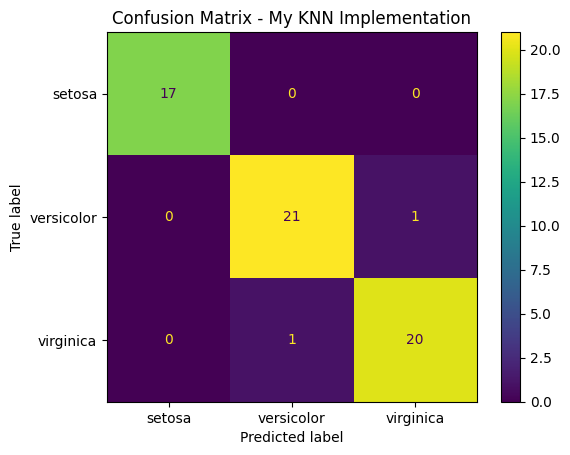


Confusion Matrix (Scikit-learn Decision Tree Implementation):
[[17  0  0]
 [ 0 21  1]
 [ 0  1 20]] 



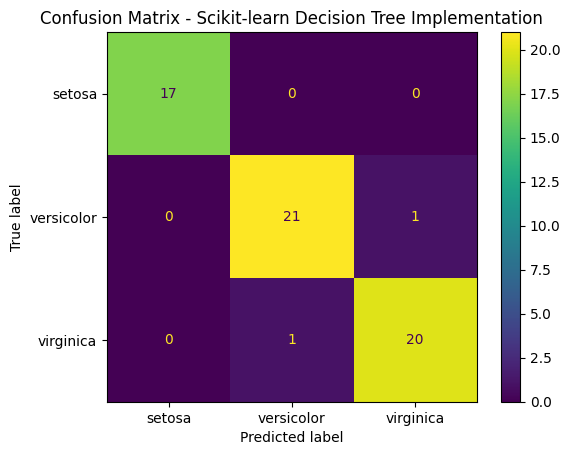

In [ ]:
# Confusion matrix for my KNN implementation
my_knn_model_predictions = my_knn_model.predict(test_examples)  # Use predictions from my knn model
my_knn_model_confusion_matrix = confusion_matrix(test_labels, my_knn_model_predictions)

print("\n Confusion Matrix (My KNN implementation):")
print(my_knn_model_confusion_matrix)


# Display the confusion matrix with labels
# Pass the labels explicitly for your custom model
my_knn_model_display = ConfusionMatrixDisplay(confusion_matrix=my_knn_model_confusion_matrix, display_labels=np.unique(test_labels))
my_knn_model_display.plot()
my_knn_model_display.ax_.set_title("Confusion Matrix - My KNN Implementation")
plt.show()



# Confusion Matrix for Decision Tree (Scikit-learn Implementation)
sklearn_knn_predictions = sklearn_knn_model.predict(test_examples)
sklearn_knn_confusion_matrix = confusion_matrix(test_labels, sklearn_knn_predictions)

print("\nConfusion Matrix (Scikit-learn Decision Tree Implementation):")
print(sklearn_knn_confusion_matrix, "\n")

# Display the confusion matrix with labels
sklearn_knn_display = ConfusionMatrixDisplay(confusion_matrix=sklearn_knn_confusion_matrix, display_labels=sklearn_knn_model.classes_)
sklearn_knn_display.plot()
sklearn_knn_display.ax_.set_title("Confusion Matrix - Scikit-learn Decision Tree Implementation")
plt.show()  # Use plt.show() to display the plot

### **Naive Bayes Classifier Implementation For iris Dataset**

In [ ]:
# model training and model evaluation steps (my implementation)
# Create a "Naive Bayes" classifier
my_nb_model = MyNaiveBayesClassifier()

# Model fitting / predictions
my_nb_model.fit(train_examples, train_labels)
my_nb_predictions = my_nb_model.predict(test_examples)

# Calculate accuracy
correct_predictions = sum(my_nb_predictions == test_labels)
accuracy = correct_predictions / len(test_labels)
print("Accuracy (My Naive Bayes implementation):", accuracy, "(or", round(accuracy*100, 1), "%)")



# model training and model evaluation steps (scikit-learn implementation)
# Create and train a scikit-learn Naive Bayes model
sklearn_model = GaussianNB()

# Fitting / Predictions with scikit-learn model
sklearn_model.fit(train_examples, train_labels)
sklearn_predictions = sklearn_model.predict(test_examples)

# Calculate accuracy for scikit-learn model
sklearn_accuracy = sum(sklearn_predictions == test_labels) / len(test_labels)
print("Accuracy (scikit-learn Naive Bayes implementation):", sklearn_accuracy, "(or", round(sklearn_accuracy*100, 1), "%)")

Accuracy (My Naive Bayes implementation): 0.95 (or 95.0 %)
Accuracy (scikit-learn Naive Bayes implementation): 0.95 (or 95.0 %)


#### **EVALUATION: Naive Bayes Classifier Implementation For iris Dataset**

Confusion Matrix (My Naive Bayes Implementation):
[[17  0  0]
 [ 0 20  2]
 [ 0  1 20]]

 Confusion Matrix (Scikit-learn Naive Bayes Implementation):
[[17  0  0]
 [ 0 20  2]
 [ 0  1 20]]


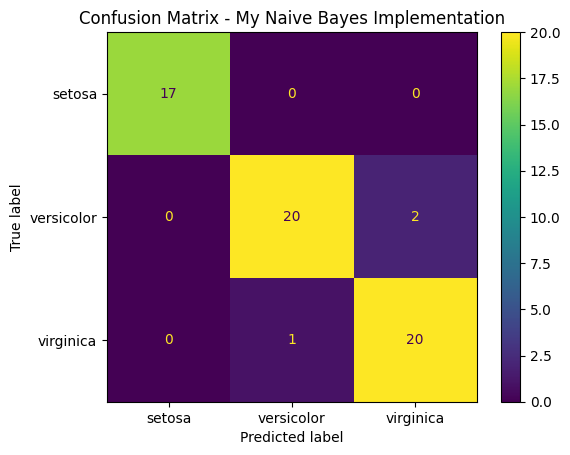

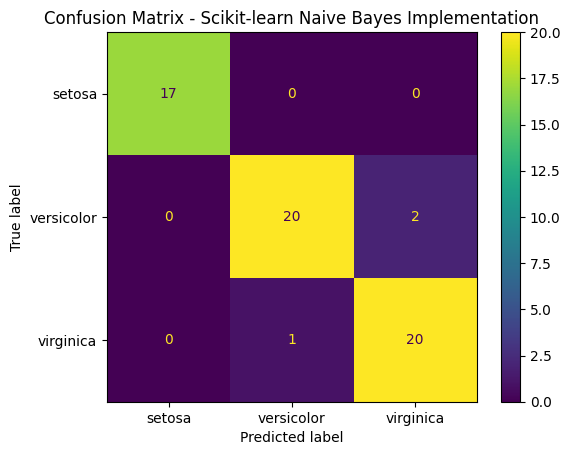

In [ ]:
#Confusion Matrix for Naive Bayes (My Implementation)
my_nb_predictions = my_nb_model.predict(test_examples)  # Use predictions from your custom NB model
my_nb_confusion_matrix = confusion_matrix(test_labels, my_nb_predictions)

print("Confusion Matrix (My Naive Bayes Implementation):")
print(my_nb_confusion_matrix)

# Display the confusion matrix with labels
my_nb_display = ConfusionMatrixDisplay(confusion_matrix=my_nb_confusion_matrix, display_labels=np.unique(train_labels))
my_nb_display.plot()
my_nb_display.ax_.set_title("Confusion Matrix - My Naive Bayes Implementation")
my_nb_display.figure_.show()


#Confusion Matrix for Naive Bayes (Scikit-learn Implementation)
# Confusion matrix for scikit-learn Naive Bayes implementation
sklearn_nb_predictions = sklearn_model.predict(test_examples)
sklearn_nb_confusion_matrix = confusion_matrix(test_labels, sklearn_nb_predictions)

print("\n Confusion Matrix (Scikit-learn Naive Bayes Implementation):")
print(sklearn_nb_confusion_matrix)

# Display the confusion matrix with labels
sklearn_nb_display = ConfusionMatrixDisplay(confusion_matrix=sklearn_nb_confusion_matrix, display_labels=sklearn_model.classes_)
sklearn_nb_display.plot()
sklearn_nb_display.ax_.set_title("Confusion Matrix - Scikit-learn Naive Bayes Implementation")
sklearn_nb_display.figure_.show()

### **Decision Tree Classifier Implementation For iris Dataset**

In [ ]:
# Hyperparameter range for max_depth
max_depth_range = range(1, 11)  # Test max_depth from 1 to 10
my_DT_model_accuracies = []
sklearn_model_accuracies = []


# Evaluate for each max_depth
for max_depth in max_depth_range:
    # Train and evaluate MyDecisionTreeClassifier
    my_DT_model = MyDecisionTreeClassifier(max_depth=max_depth)

    # Call the model's fitting algorithm, passing in our training examples and training labels
    my_DT_model.fit(train_examples, train_labels)
    # Use the trained model to generate predictions for our testing examples
    my_predictions = my_DT_model.predict(test_examples)

    my_accuracy = sum(my_predictions == test_labels) / len(test_labels)
    my_DT_model_accuracies.append(my_accuracy)




    # Model training and evaluation (scikit-learn Decision Tree Classifier)
    # Create a "Decision Tree" classifier
    sklearn_model = DecisionTreeClassifier(max_depth=max_depth)

    # Call the model's fitting algorithm, passing in our training examples and training labels
    sklearn_model.fit(train_examples, train_labels)
    # Use the trained model to generate predictions for our testing examples
    sklearn_predictions = sklearn_model.predict(test_examples)

    # Find the total number of model predictions that matched with the corresponding testing labels
    sklearn_accuracy = sum(sklearn_predictions == test_labels) / len(test_labels)
    sklearn_model_accuracies.append(sklearn_accuracy)

**Difference in Results**
1. Stochastic due to random sampling and feature selection
2. Differences in Algorithm Implementation

#### **EVALUATION: Decision Tree Classifier Implementation For iris Dataset**

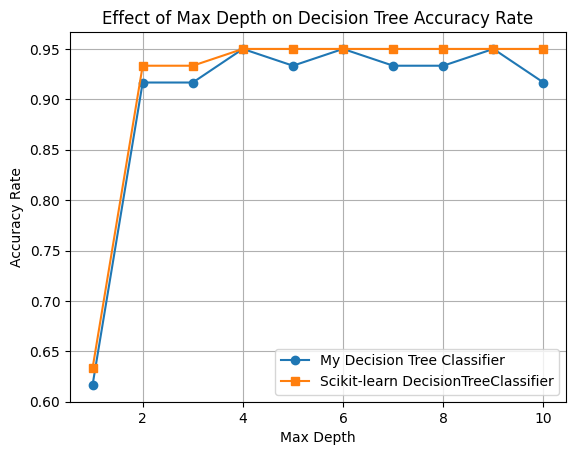


Confusion Matrix (My Decision Tree Implementation):
[[16  1  0]
 [ 0 19  3]
 [ 0  1 20]] 



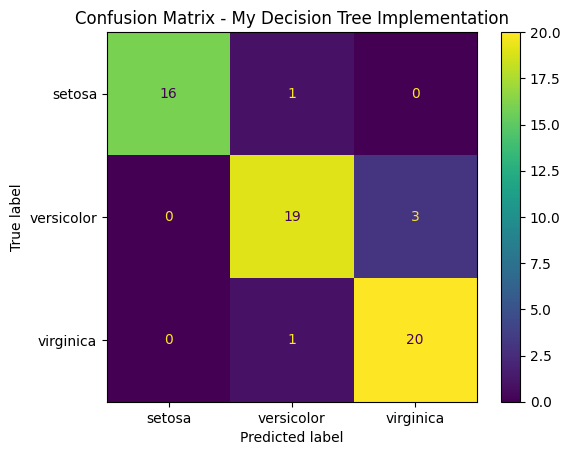


Confusion Matrix (Scikit-learn Decision Tree Implementation):
[[17  0  0]
 [ 0 20  2]
 [ 0  1 20]] 



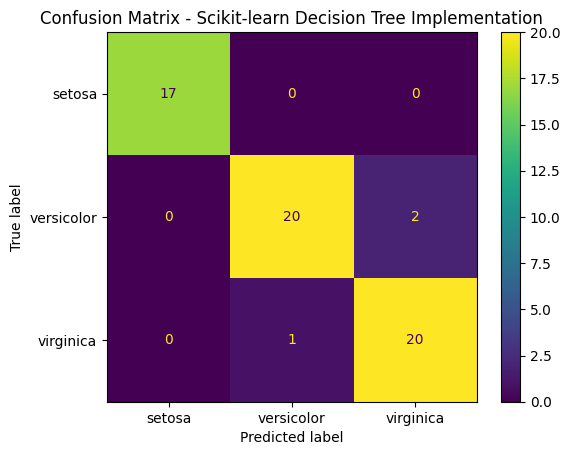

In [ ]:
# Plot the results
plt.figure()
plt.plot(max_depth_range, my_DT_model_accuracies, label="My Decision Tree Classifier", marker='o')
plt.plot(max_depth_range, sklearn_model_accuracies, label="Scikit-learn DecisionTreeClassifier", marker='s')
plt.title("Effect of Max Depth on Decision Tree Accuracy Rate")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Rate")
plt.legend()
plt.grid(True)
plt.show()


# Confusion Matrix for Decision Tree (Custom Implementation)
my_dt_predictions = my_DT_model.predict(test_examples)  # Use predictions from your custom DT model
my_dt_confusion_matrix = confusion_matrix(test_labels, my_dt_predictions)

print("\nConfusion Matrix (My Decision Tree Implementation):")
print(my_dt_confusion_matrix, "\n")

# Display the confusion matrix with labels
my_dt_display = ConfusionMatrixDisplay(confusion_matrix=my_dt_confusion_matrix, display_labels=np.unique(test_labels))
my_dt_display.plot()
my_dt_display.ax_.set_title("Confusion Matrix - My Decision Tree Implementation")
plt.show()  # Use plt.show() to display the plot


# Confusion Matrix for Decision Tree (Scikit-learn Implementation)
sklearn_dt_predictions = sklearn_model.predict(test_examples)
sklearn_dt_confusion_matrix = confusion_matrix(test_labels, sklearn_dt_predictions)

print("\nConfusion Matrix (Scikit-learn Decision Tree Implementation):")
print(sklearn_dt_confusion_matrix, "\n")

# Display the confusion matrix with labels
sklearn_dt_display = ConfusionMatrixDisplay(confusion_matrix=sklearn_dt_confusion_matrix, display_labels=sklearn_model.classes_)
sklearn_dt_display.plot()
sklearn_dt_display.ax_.set_title("Confusion Matrix - Scikit-learn Decision Tree Implementation")
plt.show()  # Use plt.show() to display the plot


### **My Ensemble DT Classifier Implementation For iris Dataset**

In [ ]:
# Encode target labels as numeric values because classifiers require numerical input.
label_encoder = LabelEncoder()
observations[target_feature] = label_encoder.fit_transform(observations[target_feature])

# Instantiate custom models for flexibility and interpretability in predictions.
knn = MyKnnClassifier(k=15)  # KNN is simple and effective for low-dimensional data.
gnb = MyNaiveBayesClassifier()  # GNB is ideal for small datasets with Gaussian features.
dt = MyDecisionTreeClassifier(max_depth=5)  # Decision Trees provide intuitive splits and are robust.

# Combine models into an ensemble for better accuracy and robustness using hard voting.
ensemble = MyEnsembleClassifier(base_models=[knn, gnb, dt], voting="hard", feature_sampling=True)

# Train the ensemble model on the training data.
ensemble.fit(train_examples, train_labels)

# Predict and evaluate the ensemble model on the test data.
y_pred = ensemble.predict(test_examples)
print("Accuracy (Ensemble Hard Voting):", accuracy_score(test_labels, y_pred))


# Compare with Scikit-learn's implementation for validation and benchmarking.
sk_knn = KNeighborsClassifier(n_neighbors=15)
sk_gnb = GaussianNB()
sk_dt = DecisionTreeClassifier(max_depth=5)

# Create a Scikit-learn ensemble model with hard voting.
sk_ensemble = VotingClassifier(
    estimators=[("knn", sk_knn), ("gnb", sk_gnb), ("dt", sk_dt)], voting="hard"
)

# Train the Scikit-learn ensemble on the same training data.
sk_ensemble.fit(train_examples, train_labels)

# Predict and evaluate Scikit-learn's ensemble on the test data.
sk_y_pred = sk_ensemble.predict(test_examples)
print("Accuracy (Scikit-learn Hard Votig)", accuracy_score(test_labels, sk_y_pred))

Accuracy (Ensemble Hard Voting): 0.9833333333333333
Accuracy (Scikit-learn Hard Votig) 0.9666666666666667


#### **EVALUATION: My Ensemble DT Classifier Implementation For iris Dataset**

Average Accuracy (Custom Ensemble): 0.9533
Average Accuracy (Scikit-learn Ensemble): 0.9633


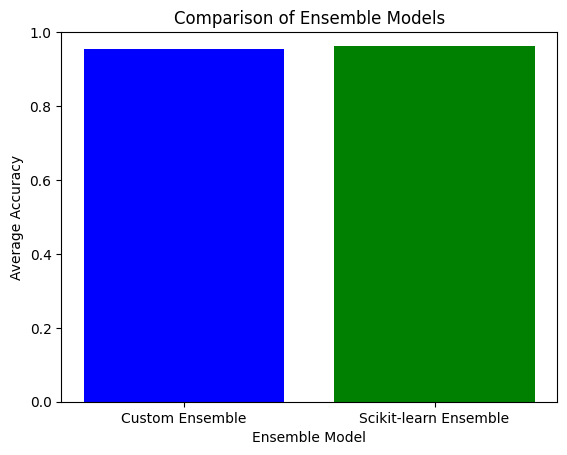

In [ ]:
# Define the number of splits for evaluation
n_splits = 5
ensemble_accuracies = []
sk_ensemble_accuracies = []

# Perform the evaluation over multiple train-test splits
for _ in range(n_splits):
    # Split the data into training and testing sets (80% train, 20% test)
    train_data, test_data = train_test_split(observations, test_size=0.4, random_state=99)

    # Extract the features and labels for training and testing
    train_examples = train_data.drop(columns=target_feature).to_numpy()
    train_labels = train_data[target_feature].to_numpy()
    test_examples = test_data.drop(columns=target_feature).to_numpy()
    test_labels = test_data[target_feature].to_numpy()

    # Reinitialize the ensemble model for each split to avoid previous state interference
    ensemble = MyEnsembleClassifier(base_models=[knn, gnb, dt], voting="hard", feature_sampling=True)

    # Train the custom ensemble model
    ensemble.fit(train_examples, train_labels)

    # Predict using the ensemble model and calculate accuracy
    y_pred = ensemble.predict(test_examples)
    ensemble_accuracy = accuracy_score(test_labels, y_pred)
    ensemble_accuracies.append(ensemble_accuracy)

    # Reinitialize the Scikit-learn ensemble model for each split
    sk_knn = KNeighborsClassifier(n_neighbors=15)
    sk_gnb = GaussianNB()
    sk_dt = DecisionTreeClassifier(max_depth=5)
    sk_ensemble = VotingClassifier(
        estimators=[("knn", sk_knn), ("gnb", sk_gnb), ("dt", sk_dt)], voting="hard"
    )

    # Train the Scikit-learn ensemble model
    sk_ensemble.fit(train_examples, train_labels)

    # Predict using the Scikit-learn ensemble model and calculate accuracy
    sk_y_pred = sk_ensemble.predict(test_examples)
    sk_ensemble_accuracy = accuracy_score(test_labels, sk_y_pred)
    sk_ensemble_accuracies.append(sk_ensemble_accuracy)

# Calculate the average accuracy for the custom ensemble and Scikit-learn ensemble
average_ensemble_accuracy = np.mean(ensemble_accuracies)
average_sk_ensemble_accuracy = np.mean(sk_ensemble_accuracies)

# Print the results
print(f"Average Accuracy (Custom Ensemble): {average_ensemble_accuracy:.4f}")
print(f"Average Accuracy (Scikit-learn Ensemble): {average_sk_ensemble_accuracy:.4f}")

# Plot the average accuracies
labels = ['Custom Ensemble', 'Scikit-learn Ensemble']
accuracies = [average_ensemble_accuracy, average_sk_ensemble_accuracy]

plt.bar(labels, accuracies, color=['blue', 'green'])
plt.title('Comparison of Ensemble Models')
plt.xlabel('Ensemble Model')
plt.ylabel('Average Accuracy')
plt.ylim([0, 1])  # Accuracy ranges from 0 to 1
plt.show()


## **moons Dataset**

In [ ]:
# Load all the observations from file
observations = pd.read_csv('moons.csv')

# Data Info
print(observations)
print("Number of observations:", observations.shape, "\n")
# Set the name of the target feature
target_feature = 'Label'

# Shuffle all the observations
observations_shuffled = observations.sample(frac=1, random_state=99)

# Set the fraction of observations we will use for testing
testing_fraction = 0.4
split_index = int(observations_shuffled.shape[0] * testing_fraction)

# Split into testing observations and training observations ("horizontal split")
observations_test = observations_shuffled.iloc[:split_index]
observations_train = observations_shuffled.iloc[split_index:]

# Split into testing examples and testing labels ("vertical split")
test_examples = observations_test.drop(columns=target_feature).to_numpy()
test_labels = observations_test[target_feature].to_numpy()

# Split into training examples and training labels ("vertical split")
train_examples = observations_train.drop(columns=target_feature).to_numpy()
train_labels = observations_train[target_feature].to_numpy()

     Feature 1  Feature 2    Label
0     0.156736   1.318172  Class A
1    -0.970543   0.621054  Class A
2    -0.908623   0.159812  Class A
3     0.707644   0.260445  Class A
4    -1.232510   0.927917  Class A
..         ...        ...      ...
145   1.557741   0.035428  Class B
146  -0.121047  -0.090839  Class B
147   0.217841   0.658837  Class B
148   1.864451  -0.257722  Class B
149   0.225822   0.335673  Class B

[150 rows x 3 columns]
Number of observations: (150, 3) 



### **KNN Classifier Implementation For moons Dataset:**

In [ ]:
# Model training and evaluation steps (my implementation)
# Create a "KNN" classifier using a K value
my_knn_model = MyKnnClassifier(k=5)

# Call the model's fitting algorithm, passing in our training examples and training labels
my_knn_model.fit(train_examples, train_labels)
# Use the trained model to generate predictions for our testing examples
my_knn_predictions = my_knn_model.predict(test_examples)

# Find the total number of model predictions that matched with the corresponding testing labels
correct_predictions_my_knn = np.sum(my_knn_predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy_my_knn = correct_predictions_my_knn / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (my KNN implementation):", accuracy_my_knn, "(or", round(accuracy_my_knn * 100, 1), "%)")



# model training and model evaluation steps (scikit-learn implementation)
# Create a "KNN" classifier with no hyperparameter
sklearn_knn_model = KNeighborsClassifier(n_neighbors=5)

# Call the model's fitting algorithm, passing in our training examples and training labels
sklearn_knn_model.fit(train_examples, train_labels)
# Use the trained model to generate predictions for our testing examples
predictions = sklearn_knn_model.predict(test_examples)

# Find the total number of model predictions that matched with the corresponding testing labels
correct_predictions = sum(predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy = correct_predictions / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (scikit-learn KNN implementation):", accuracy, "(or", round(accuracy*100, 1), "%)")

Accuracy (my KNN implementation): 0.9166666666666666 (or 91.7 %)
Accuracy (scikit-learn KNN implementation): 0.9166666666666666 (or 91.7 %)


#### **EVALUATION: KNN Classifier Implementation For moons Dataset**

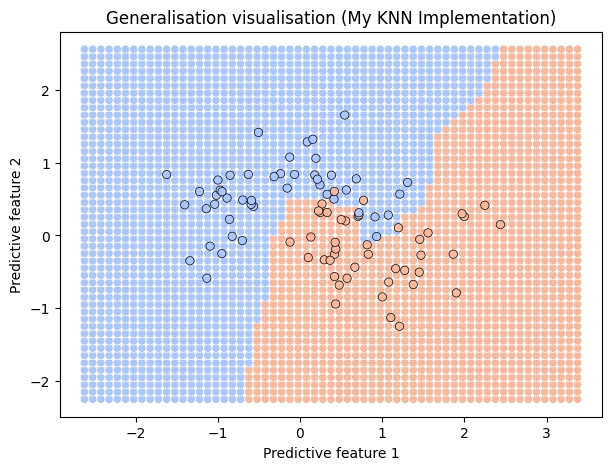

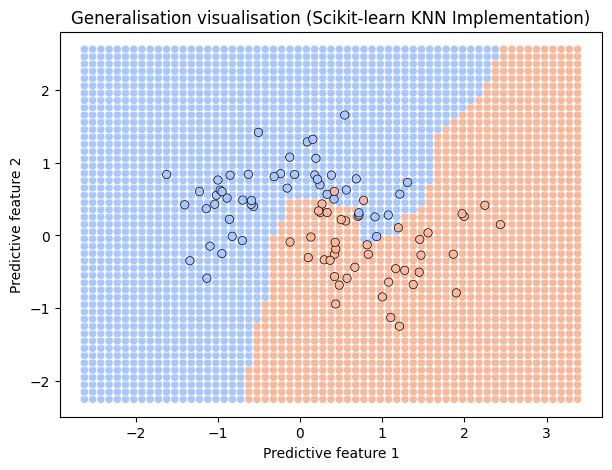

In [ ]:
# Prepare our own grid of testing examples to use in visualisation
x_min = train_examples[:, 0].min() - 1
x_max = train_examples[:, 0].max() + 1
y_min = train_examples[:, 1].min() - 1
y_max = train_examples[:, 1].max() + 1
# adjust this to get more/less definition in the grid (takes more/less time, may need smaller plot points below)
jump = 0.1
# Get help from numpy's meshgrid() function to be fast
grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, jump), np.arange(y_min, y_max, jump))
# Turn the results back into a deep table with only 2 columns
grid_examples = np.c_[grid_x.ravel(), grid_y.ravel()]

# Make predictions for each of the examples in the grid
grid_predictions = my_knn_model.predict(grid_examples)

# Visualise the final generalisation
plt.figure(figsize=(7, 5))
# Plot the generalisation (Seaborn lets us supply strings as hue values)
sns.scatterplot(x=grid_examples[:, 0], y=grid_examples[:, 1], hue=grid_predictions, palette='coolwarm', legend=False)
# Plot the training data (Seaborn lets us supply strings as hue values)
sns.scatterplot(x=train_examples[:, 0], y=train_examples[:, 1], hue=train_labels, palette='coolwarm', edgecolor='k', legend=False)
plt.xlabel('Predictive feature 1')
plt.ylabel('Predictive feature 2')
plt.title('Generalisation visualisation (My KNN Implementation)')
plt.show()




# Make predictions for the grid examples
grid_predictions_sklearn = sklearn_knn_model.predict(grid_examples)
# Visualise the final generalization for sklearn's KNN model
plt.figure(figsize=(7, 5))

# Plot the decision boundary with grid examples
sns.scatterplot(x=grid_examples[:, 0], y=grid_examples[:, 1], hue=grid_predictions_sklearn, palette='coolwarm', legend=False)
# Plot the training data with the corresponding labels
sns.scatterplot(x=train_examples[:, 0], y=train_examples[:, 1], hue=train_labels, palette='coolwarm', edgecolor='k', legend=False)

plt.xlabel('Predictive feature 1')
plt.ylabel('Predictive feature 2')
plt.title('Generalisation visualisation (Scikit-learn KNN Implementation)')
plt.show()


### **Naive Bayes Classifier Implementation For moons Dataset**

In [ ]:
# model training and model evaluation steps (my implementation)
# Create a "Naive Bayes" classifier
my_nb_model = MyNaiveBayesClassifier()

# Model fitting / predictions
my_nb_model.fit(train_examples, train_labels)
my_nb_predictions = my_nb_model.predict(test_examples)

# Calculate accuracy
correct_predictions = sum(my_nb_predictions == test_labels)
accuracy = correct_predictions / len(test_labels)
print("Accuracy (My Naive Bayes implementation):", accuracy, "(or", round(accuracy*100, 1), "%)")



# model training and model evaluation steps (scikit-learn implementation)
# Create and train a scikit-learn Naive Bayes model
sklearn_NB_model = GaussianNB()

# Fitting / Predictions with scikit-learn model
sklearn_NB_model.fit(train_examples, train_labels)
sklearn_predictions = sklearn_NB_model.predict(test_examples)

# Calculate accuracy for scikit-learn model
sklearn_accuracy = sum(sklearn_predictions == test_labels) / len(test_labels)
print("Accuracy (scikit-learn Naive Bayes implementation):", sklearn_accuracy, "(or", round(sklearn_accuracy*100, 1), "%)")

Accuracy (My Naive Bayes implementation): 0.85 (or 85.0 %)
Accuracy (scikit-learn Naive Bayes implementation): 0.85 (or 85.0 %)


#### **EVALUATION: Naive Bayes Classifier Implementation For moons Dataset**

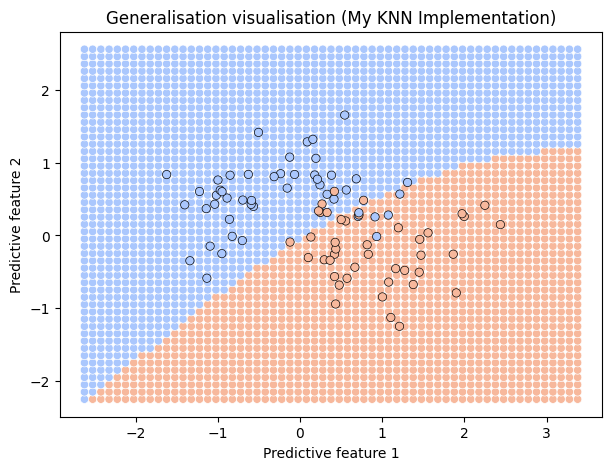

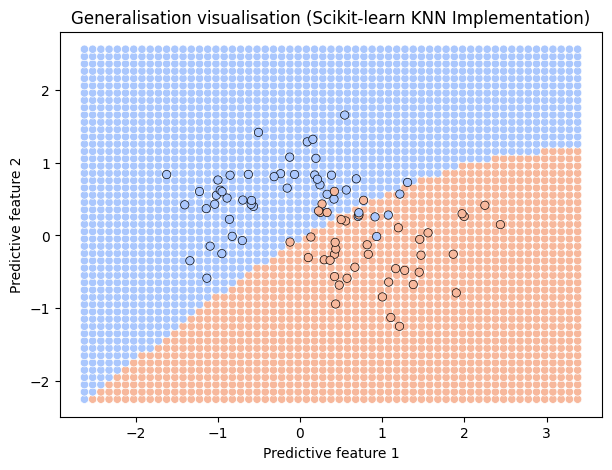

In [ ]:
# Prepare our own grid of testing examples to use in visualisation
x_min = train_examples[:, 0].min() - 1
x_max = train_examples[:, 0].max() + 1
y_min = train_examples[:, 1].min() - 1
y_max = train_examples[:, 1].max() + 1
# adjust this to get more/less definition in the grid (takes more/less time, may need smaller plot points below)
jump = 0.1
# Get help from numpy's meshgrid() function to be fast
grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, jump), np.arange(y_min, y_max, jump))
# Turn the results back into a deep table with only 2 columns
grid_examples = np.c_[grid_x.ravel(), grid_y.ravel()]

# Make predictions for each of the examples in the grid
grid_predictions = my_nb_model.predict(grid_examples)

# Visualise the final generalisation
plt.figure(figsize=(7, 5))
# Plot the generalisation (Seaborn lets us supply strings as hue values)
sns.scatterplot(x=grid_examples[:, 0], y=grid_examples[:, 1], hue=grid_predictions, palette='coolwarm', legend=False)
# Plot the training data (Seaborn lets us supply strings as hue values)
sns.scatterplot(x=train_examples[:, 0], y=train_examples[:, 1], hue=train_labels, palette='coolwarm', edgecolor='k', legend=False)
plt.xlabel('Predictive feature 1')
plt.ylabel('Predictive feature 2')
plt.title('Generalisation visualisation (My KNN Implementation)')
plt.show()



# (scikit-learn implementation)
# Make predictions for the grid examples
grid_predictions_sklearn = sklearn_NB_model.predict(grid_examples)
# Visualise the final generalization for sklearn's KNN model
plt.figure(figsize=(7, 5))

# Plot the decision boundary with grid examples
sns.scatterplot(x=grid_examples[:, 0], y=grid_examples[:, 1], hue=grid_predictions_sklearn, palette='coolwarm', legend=False)
# Plot the training data with the corresponding labels
sns.scatterplot(x=train_examples[:, 0], y=train_examples[:, 1], hue=train_labels, palette='coolwarm', edgecolor='k', legend=False)

plt.xlabel('Predictive feature 1')
plt.ylabel('Predictive feature 2')
plt.title('Generalisation visualisation (Scikit-learn KNN Implementation)')
plt.show()

### **Decision Tree Classifier Implementation For moons Dataset:**

In [ ]:
# Model training and evaluation (My Decision Tree Classifier)
# Create a "Decision Tree" classifier
my_dt_model = MyDecisionTreeClassifier()

# Call the model's fitting algorithm, passing in our training examples and training labels
my_dt_model.fit(train_examples, train_labels)
# Use the trained model to generate predictions for our testing examples
my_dt_predictions = my_dt_model.predict(test_examples)

# Find the total number of model predictions that matched with the corresponding testing labels
correct_predictions = sum(my_dt_predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy = correct_predictions / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (My Decision Tree Classifier implementation):", accuracy, "(or", round(accuracy * 100, 1), "%)")



# Model training and evaluation (scikit-learn Decision Tree Classifier)
# Create a "Decision Tree" classifier
sklearn_dt_model = DecisionTreeClassifier()

# Call the model's fitting algorithm, passing in our training examples and training labels
sklearn_dt_model.fit(train_examples, train_labels)
# Use the trained model to generate predictions for our testing examples
predictions = sklearn_dt_model.predict(test_examples)

# Find the total number of model predictions that matched with the corresponding testing labels
correct_predictions = sum(predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy = correct_predictions / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (scikit-learn Decision Tree Classifier implementation):", accuracy, "(or", round(accuracy * 100, 1), "%)")

Accuracy (My Decision Tree Classifier implementation): 0.8666666666666667 (or 86.7 %)
Accuracy (scikit-learn Decision Tree Classifier implementation): 0.8 (or 80.0 %)


#### **EVALUATION: Decision Tree Classifier Implementation For moons Dataset**

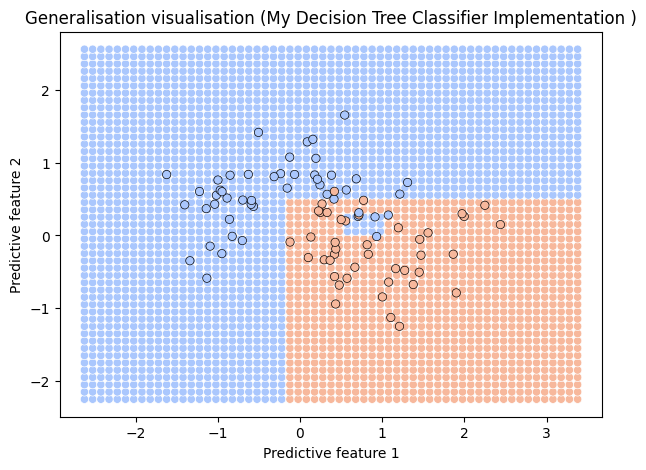

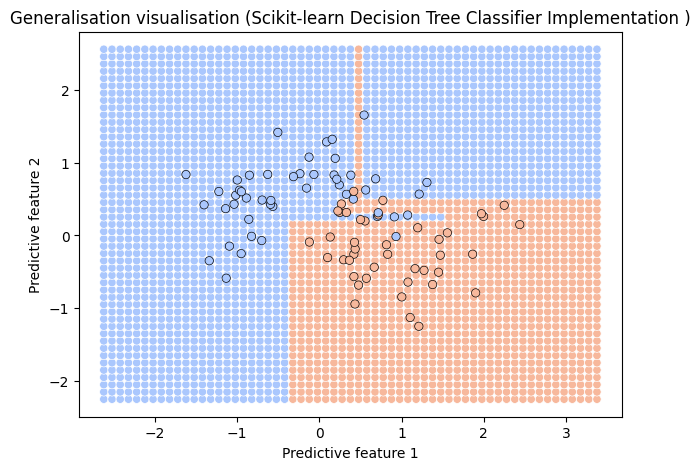

In [ ]:
# Prepare our own grid of testing examples to use in visualisation
x_min = train_examples[:, 0].min() - 1
x_max = train_examples[:, 0].max() + 1
y_min = train_examples[:, 1].min() - 1
y_max = train_examples[:, 1].max() + 1
# adjust this to get more/less definition in the grid (takes more/less time, may need smaller plot points below)
jump = 0.1
# Get help from numpy's meshgrid() function to be fast
grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, jump), np.arange(y_min, y_max, jump))
# Turn the results back into a deep table with only 2 columns
grid_examples = np.c_[grid_x.ravel(), grid_y.ravel()]

# Make predictions for each of the examples in the grid
grid_predictions = my_dt_model.predict(grid_examples)

# Visualise the final generalisation
plt.figure(figsize=(7, 5))
# Plot the generalisation (Seaborn lets us supply strings as hue values)
sns.scatterplot(x=grid_examples[:, 0], y=grid_examples[:, 1], hue=grid_predictions, palette='coolwarm', legend=False)
# Plot the training data (Seaborn lets us supply strings as hue values)
sns.scatterplot(x=train_examples[:, 0], y=train_examples[:, 1], hue=train_labels, palette='coolwarm', edgecolor='k', legend=False)
plt.xlabel('Predictive feature 1')
plt.ylabel('Predictive feature 2')
plt.title('Generalisation visualisation (My Decision Tree Classifier Implementation )')
plt.show()
print("\n")




# Make predictions for the grid examples
grid_predictions_sklearn = sklearn_dt_model.predict(grid_examples)
# Visualise the final generalization for sklearn's KNN model
plt.figure(figsize=(7, 5))

# Plot the decision boundary with grid examples
sns.scatterplot(x=grid_examples[:, 0], y=grid_examples[:, 1], hue=grid_predictions_sklearn, palette='coolwarm', legend=False)
# Plot the training data with the corresponding labels
sns.scatterplot(x=train_examples[:, 0], y=train_examples[:, 1], hue=train_labels, palette='coolwarm', edgecolor='k', legend=False)
plt.xlabel('Predictive feature 1')
plt.ylabel('Predictive feature 2')
plt.title('Generalisation visualisation (Scikit-learn Decision Tree Classifier Implementation )')
plt.show()

## **biopsies Dataset**

In [ ]:
# Load all the observations from file
observations = pd.read_csv('biopsies.csv')
# Learn about my dataset
# Data Info
print(observations)
print("Number of observations:", observations.shape, "\n")
# Set the name of the target feature
target_feature = 'diagnosis'

# Shuffling all the observations
observations_shuffled = observations.sample(frac=1, random_state=99)

# Setting the fraction of observations we will use for testing
testing_fraction = 0.4
split_index = int(observations_shuffled.shape[0] * testing_fraction)

# Splitting into testing observations and training observations ("horizontal split")
observations_test = observations_shuffled.iloc[:split_index]
observations_train = observations_shuffled.iloc[split_index:]

# Splitting into testing examples and testing labels ("vertical split")
test_examples = observations_test.drop(columns = target_feature).to_numpy()
test_labels = observations_test[target_feature].to_numpy()

# Splitting into training examples and training labels ("vertical split")
train_examples = observations_train.drop(columns=target_feature).to_numpy()
train_labels = observations_train[target_feature].to_numpy()

    diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0           B       13.540         14.36           87.46      566.3   
1           B       13.080         15.71           85.63      520.0   
2           B        9.504         12.44           60.34      273.9   
3           B       13.030         18.42           82.61      523.8   
4           B        8.196         16.84           51.71      201.9   
..        ...          ...           ...             ...        ...   
564         M       20.920         25.09          143.00     1347.0   
565         M       21.560         22.39          142.00     1479.0   
566         M       20.130         28.25          131.20     1261.0   
567         M       16.600         28.08          108.30      858.1   
568         M       20.600         29.33          140.10     1265.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0            0.09779           0.08129         0.06664             0

### **KNN Classifier Implementation For biopsies Dataset:**

In [ ]:
# Model training and evaluation steps (my implementation)
# Create a "KNN" classifier using a K value
my_knn_model = MyKnnClassifier(k=5)

# Call the model's fitting algorithm, passing in our training examples and training labels
my_knn_model.fit(train_examples, train_labels)
# Use the trained model to generate predictions for our testing examples
my_knn_predictions = my_knn_model.predict(test_examples)

# Find the total number of model predictions that matched with the corresponding testing labels
correct_predictions_my_knn = np.sum(my_knn_predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy_my_knn = correct_predictions_my_knn / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (my KNN implementation):", accuracy_my_knn, "(or", round(accuracy_my_knn * 100, 1), "%)")



# model training and model evaluation steps (scikit-learn implementation)
# Create a "KNN" classifier with no hyperparameter
sklearn_knn_model = KNeighborsClassifier(n_neighbors=5)

# Call the model's fitting algorithm, passing in our training examples and training labels
sklearn_knn_model.fit(train_examples, train_labels)
# Use the trained model to generate predictions for our testing examples
predictions = sklearn_knn_model.predict(test_examples)

# Find the total number of model predictions that matched with the corresponding testing labels
correct_predictions = sum(predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy = correct_predictions / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (scikit-learn KNN implementation):", accuracy, "(or", round(accuracy*100, 1), "%)")


Accuracy (my KNN implementation): 0.9118942731277533 (or 91.2 %)
Accuracy (scikit-learn KNN implementation): 0.9118942731277533 (or 91.2 %)


#### **EVALUATION: KNN Classifier Implementation For biopsies Dataset**

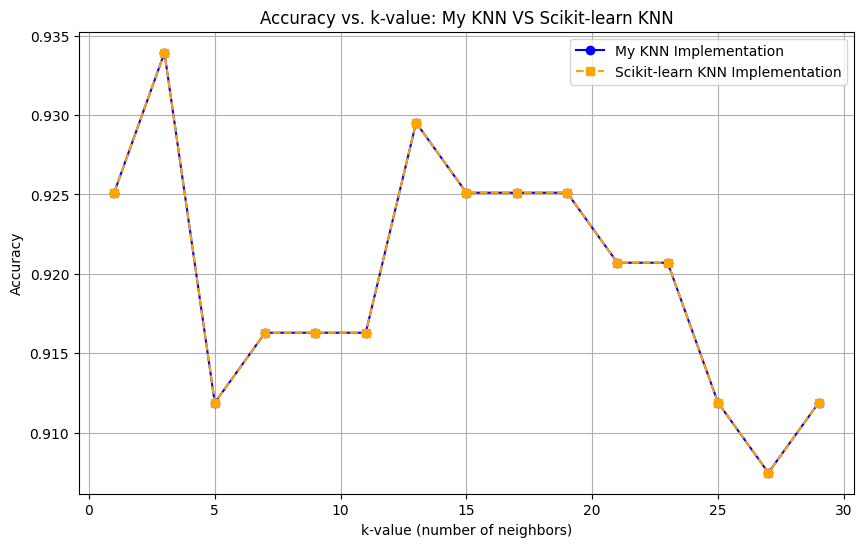

In [ ]:
# Range of k-values
k_vals = list(range(1, 30, 2))

# Lists to store accuracies
my_knn_accuracies = []
sklearn_knn_accuracies = []

# Loop through each k value
for k in k_vals:
    # MyKnnClassifier (your custom implementation)
    my_knn_model = MyKnnClassifier(k=k)
    my_knn_model.fit(train_examples, train_labels)
    my_predictions = my_knn_model.predict(test_examples)
    my_accuracy = sum(my_predictions == test_labels) / len(test_labels)
    my_knn_accuracies.append(my_accuracy)

    # Scikit-learn's KNN
    sklearn_knn_model = KNeighborsClassifier(n_neighbors=k)
    sklearn_knn_model.fit(train_examples, train_labels)
    sklearn_predictions = sklearn_knn_model.predict(test_examples)
    sklearn_accuracy = sum(sklearn_predictions == test_labels) / len(test_labels)
    sklearn_knn_accuracies.append(sklearn_accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_vals, my_knn_accuracies, label="My KNN Implementation", marker='o', linestyle='-', color='blue')
plt.plot(k_vals, sklearn_knn_accuracies, label="Scikit-learn KNN Implementation", marker='s', linestyle='--', color='orange')

# Add labels, title, and legend
plt.xlabel("k-value (number of neighbors)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. k-value: My KNN VS Scikit-learn KNN")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### **Naive Bayes Implementation For biopsies Dataset:**

In [ ]:
# model training and model evaluation steps (my implementation)
# Create a "Naive Bayes" classifier
my_nb_model = MyNaiveBayesClassifier()

# Model Fitting / Predictions
my_nb_model.fit(train_examples, train_labels)
my_nb_predictions = my_nb_model.predict(test_examples)

# Calculate accuracy
correct_predictions = sum(my_nb_predictions == test_labels)
accuracy = correct_predictions / len(test_labels)
print("Accuracy (My Naive Bayes implementation):", accuracy, "(or", round(accuracy*100, 1), "%)")



# model training and model evaluation steps (scikit-learn implementation)
# Create and train a scikit-learn Naive Bayes model
sklearn_NB_model = GaussianNB(var_smoothing=0)

# Fit the scikit-learn model
sklearn_NB_model.fit(train_examples, train_labels)
# Predictions with scikit-learn model
sklearn_predictions = sklearn_NB_model.predict(test_examples)

# Calculate accuracy for scikit-learn model
sklearn_accuracy = sum(sklearn_predictions == test_labels) / len(test_labels)
print("Accuracy (scikit-learn Naive Bayes implementation):", sklearn_accuracy, "(or", round(sklearn_accuracy*100, 1), "%)")

Accuracy (My Naive Bayes implementation): 0.9383259911894273 (or 93.8 %)
Accuracy (scikit-learn Naive Bayes implementation): 0.9383259911894273 (or 93.8 %)


#### **EVALUATION: Naive Bayes Classifier Implementation For biopsies Dataset**

Confusion Matrix (My Naive Bayes Implementation - Biopsies Dataset):
[[134   6]
 [  8  79]]

 Confusion Matrix (Scikit-learn Naive Bayes Implementation - Biopsies Dataset):
[[134   6]
 [  8  79]]


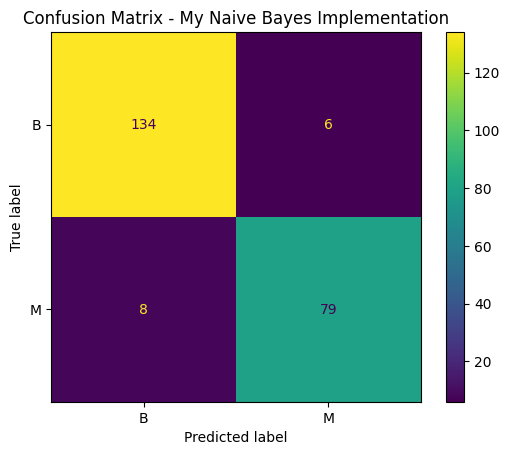

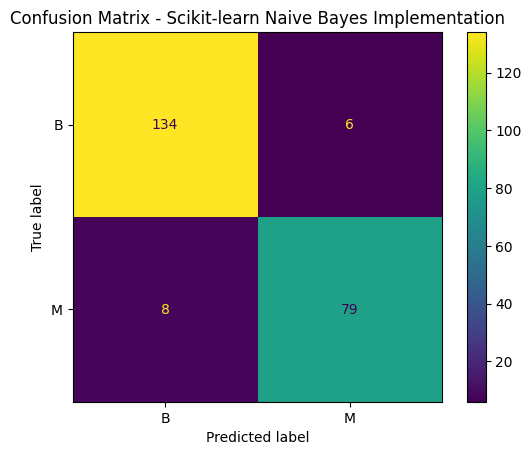

In [ ]:
# Confusion matrix for custom Naive Bayes implementation
my_nb_predictions = my_nb_model.predict(test_examples)  # Use predictions from your custom NB model
my_nb_confusion_matrix = confusion_matrix(test_labels, my_nb_predictions)

print("Confusion Matrix (My Naive Bayes Implementation - Biopsies Dataset):")
print(my_nb_confusion_matrix)

# Display the confusion matrix with labels
my_nb_display = ConfusionMatrixDisplay(confusion_matrix=my_nb_confusion_matrix, display_labels=np.unique(train_labels))
my_nb_display.plot()
my_nb_display.ax_.set_title("Confusion Matrix - My Naive Bayes Implementation")
my_nb_display.figure_.show()





# Confusion matrix for scikit-learn Naive Bayes implementation
sklearn_nb_predictions = sklearn_NB_model.predict(test_examples)
sklearn_nb_confusion_matrix = confusion_matrix(test_labels, sklearn_nb_predictions)

print("\n Confusion Matrix (Scikit-learn Naive Bayes Implementation - Biopsies Dataset):")
print(sklearn_nb_confusion_matrix)

# Display the confusion matrix with labels
sklearn_nb_display = ConfusionMatrixDisplay(confusion_matrix=sklearn_nb_confusion_matrix, display_labels=sklearn_NB_model.classes_)
sklearn_nb_display.plot()
sklearn_nb_display.ax_.set_title("Confusion Matrix - Scikit-learn Naive Bayes Implementation")
sklearn_nb_display.figure_.show()



### **Decision Tree Classifier Implementation For biopsies Dataset:**

In [ ]:
# Model training and evaluation (Custom Decision Tree Classifier)
# Create a "Decision Tree" classifier
my_DT_model = MyDecisionTreeClassifier()

# Call the model's fitting algorithm, passing in our training examples and training labels
my_DT_model.fit(train_examples, train_labels)
# Use the trained model to generate predictions for our testing examples
predictions = my_DT_model.predict(test_examples)

# Find the total number of model predictions that matched with the corresponding testing labels
correct_predictions = sum(predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy = correct_predictions / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (My Decision Tree Classifier implementation):", accuracy, "(or", round(accuracy * 100, 1), "%)")




# Model training and evaluation (scikit-learn Decision Tree Classifier)
sklearn_DT_model = DecisionTreeClassifier()

# Call the model's fitting algorithm, passing in our training examples and training labels
sklearn_DT_model.fit(train_examples, train_labels)
# Use the trained model to generate predictions for our testing examples
predictions = sklearn_DT_model.predict(test_examples)

# Find the total number of model predictions that matched with the corresponding testing labels
correct_predictions = sum(predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy = correct_predictions / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (scikit-learn Decision Tree Classifier implementation):", accuracy, "(or", round(accuracy * 100, 1), "%)")

Accuracy (My Decision Tree Classifier implementation): 0.947136563876652 (or 94.7 %)
Accuracy (scikit-learn Decision Tree Classifier implementation): 0.947136563876652 (or 94.7 %)


#### **EVALUATION: Decision Tree Classifier Implementation For biopsies Dataset**

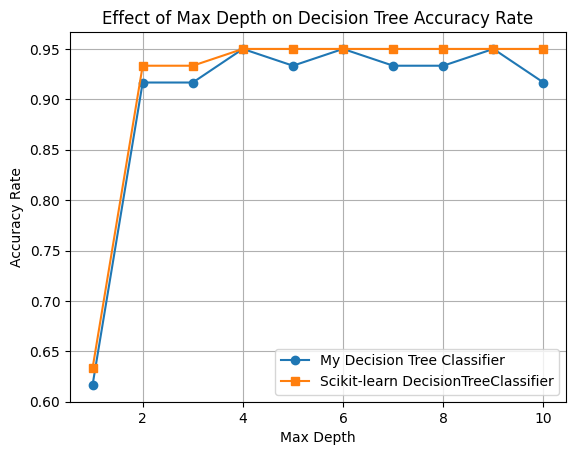


Confusion Matrix (My Decision Tree Implementation):
[[134   6]
 [  6  81]] 



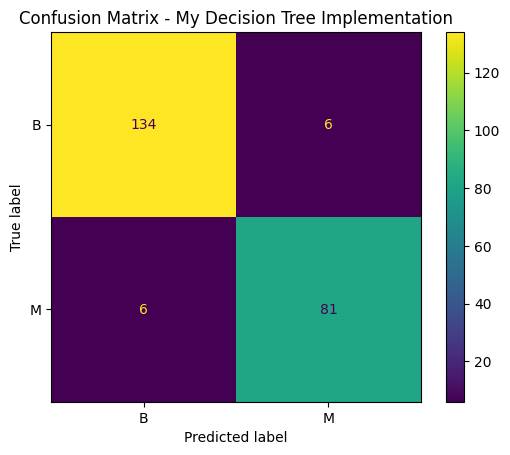


Confusion Matrix (Scikit-learn Decision Tree Implementation):
[[138   2]
 [ 10  77]] 



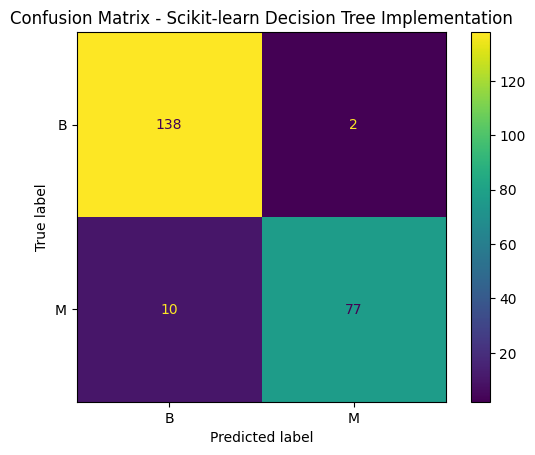

In [ ]:
# Plot the results
plt.figure()
plt.plot(max_depth_range, my_DT_model_accuracies, label="My Decision Tree Classifier", marker='o')
plt.plot(max_depth_range, sklearn_model_accuracies, label="Scikit-learn DecisionTreeClassifier", marker='s')
plt.title("Effect of Max Depth on Decision Tree Accuracy Rate")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Rate")
plt.legend()
plt.grid(True)
plt.show()


# Confusion Matrix for Decision Tree (Custom Implementation)
my_dt_predictions = my_DT_model.predict(test_examples)  # Use predictions from your custom DT model
my_dt_confusion_matrix = confusion_matrix(test_labels, my_dt_predictions)

print("\nConfusion Matrix (My Decision Tree Implementation):")
print(my_dt_confusion_matrix, "\n")

# Display the confusion matrix with labels
my_dt_display = ConfusionMatrixDisplay(confusion_matrix=my_dt_confusion_matrix, display_labels=np.unique(test_labels))
my_dt_display.plot()
my_dt_display.ax_.set_title("Confusion Matrix - My Decision Tree Implementation")
plt.show()  # Use plt.show() to display the plot


# Confusion Matrix for Decision Tree (Scikit-learn Implementation)
sklearn_dt_predictions = sklearn_DT_model.predict(test_examples)
sklearn_dt_confusion_matrix = confusion_matrix(test_labels, sklearn_dt_predictions)

print("\nConfusion Matrix (Scikit-learn Decision Tree Implementation):")
print(sklearn_dt_confusion_matrix, "\n")

# Display the confusion matrix with labels
sklearn_dt_display = ConfusionMatrixDisplay(confusion_matrix=sklearn_dt_confusion_matrix, display_labels=sklearn_DT_model.classes_)
sklearn_dt_display.plot()
sklearn_dt_display.ax_.set_title("Confusion Matrix - Scikit-learn Decision Tree Implementation")
plt.show()  # Use plt.show() to display the plot


### **HARD VOTING IMPLEMENTATION**

In [ ]:
# Create a new StandardScaler object, ready to do z-score standardisation
scaler = StandardScaler()
# Compute means and standard deviations for each feature in the training data
scaler.fit(train_examples)
# Divide individual feature values in the training data by their respective means and standard deviations:
train_examples = scaler.transform(train_examples)
# Apply the same transformation to the testing examples
test_examples = scaler.transform(test_examples)


# MY HARD VOTING ENSEMBLING IMPLEMENTATIONS
# Instantiate custom models for flexibility and interpretability in predictions.
knn = MyKnnClassifier()  # KNN is simple and effective for low-dimensional data.
gnb = MyNaiveBayesClassifier()  # GNB is ideal for small datasets with Gaussian features.
dt = MyDecisionTreeClassifier()  # Decision Trees provide intuitive splits and are robust.

# Combine models into an ensemble for better accuracy and robustness using hard voting.
ensemble_hard = MyEnsembleClassifier(base_models=[knn, gnb, dt], voting="hard", feature_sampling=True)

# Call the model's fitting/training algorithm, passing in our training examples and training labels
ensemble_hard.fit(train_examples, train_labels)
# Use the trained model to generate predictions based on our testing examples
ensemble_hard_predictions = ensemble_hard.predict(test_examples)

# Find the total number of model predictions that matched with their corresponding testing labels
correct_predictions = sum(ensemble_hard_predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
ensemble_hard_accuracy = correct_predictions / len(test_labels)
print("Accuracy (Ensemble Hard Voting):", ensemble_hard_accuracy, "(or", round(ensemble_hard_accuracy*100, 1), "%)")




#SCIKIT-LEARNS'S IMPLEMENTATIONS
# Compare with Scikit-learn's implementation for validation and benchmarking.
sk_knn = KNeighborsClassifier()
sk_gnb = GaussianNB()
sk_dt = DecisionTreeClassifier()

# Create a Scikit-learn ensemble model with hard voting.
sk_ensemble = VotingClassifier(estimators=[("knn", sk_knn), ("gnb", sk_gnb), ("dt", sk_dt)], voting="hard")

# Call the model's fitting/training algorithm, passing in our training examples and training labels
sk_ensemble.fit(train_examples, train_labels)
# Use the trained model to generate predictions based on our testing examples
predictions = sk_ensemble.predict(test_examples)

# Find the total number of model predictions that matched with their corresponding testing labels
correct_predictions = sum(predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy = correct_predictions / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (scikit-learn Hard Voting):", accuracy, "(or", round(accuracy*100, 1), "%)")

Accuracy (Ensemble Hard Voting): 0.973568281938326 (or 97.4 %)
Accuracy (scikit-learn Hard Voting): 0.973568281938326 (or 97.4 %)


#### **EVALUATION: HARD VOTING IMPLEMENTATION**

In [ ]:
from sklearn.metrics import classification_report
# Evaluate precision, recall, and F1-score for both implementations.
# Classification report for custom hard voting
print("Classification Report (My Hard Voting):")
print(classification_report(test_labels, ensemble_hard_predictions))

# Classification report for Scikit-learn's hard voting
print("Classification Report (Scikit-learn Hard Voting):")
print(classification_report(test_labels, predictions))


Classification Report (My Hard Voting):
              precision    recall  f1-score   support

           B       0.97      0.99      0.98       140
           M       0.99      0.94      0.96        87

    accuracy                           0.97       227
   macro avg       0.98      0.97      0.97       227
weighted avg       0.97      0.97      0.97       227

Classification Report (Scikit-learn Hard Voting):
              precision    recall  f1-score   support

           B       0.96      1.00      0.98       140
           M       1.00      0.93      0.96        87

    accuracy                           0.97       227
   macro avg       0.98      0.97      0.97       227
weighted avg       0.97      0.97      0.97       227



### **SOFT VOTING IMPLEMENTATION**

In [ ]:
# Combine models into an ensemble for better accuracy and robustness using soft voting.
ensemble_soft = MyEnsembleClassifier(base_models=[knn, gnb, dt], voting="soft", feature_sampling=False)

# Train the ensemble model on the training data.
ensemble_soft.fit(train_examples, train_labels)
# Predict and evaluate the ensemble model on the test data.
ensemble_soft_predictions = ensemble_soft.predict(test_examples)

# Find the total number of model predictions that matched with their corresponding testing labels
ensemble_soft_correct_predictions = sum(ensemble_soft_predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
ensemble_soft_accuracy = ensemble_soft_correct_predictions / len(test_labels)
# Display the accuracy for soft voting
print("Accuracy (Ensemble Soft Voting):", ensemble_soft_accuracy, "(or", round(ensemble_soft_accuracy*100, 1), "%)")

# predict_proba
print("Probabilities for the first test example:")
print(ensemble_soft.predict_proba(test_examples[0:1,:]))


#SCIKIT-LEARNS'S IMPLEMENTATIONS
# Create a soft-voting SK_Learn
model_soft = VotingClassifier(estimators=[("knn", sk_knn), ("gnb", sk_gnb), ("dt", sk_dt)], voting='soft')

# Call the model's fitting/training algorithm, passing in our training examples and training labels
model_soft.fit(train_examples, train_labels)
# Use the trained model to generate predictions based on our testing examples
predictions_soft = model_soft.predict(test_examples)

# Find the total number of model predictions that matched with their corresponding testing labels
correct_predictions_soft = sum(predictions_soft == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy_soft = correct_predictions_soft / len(test_labels)
# Display the accuracy for soft voting
print("\nAccuracy (scikit-learn Soft Voting)::", accuracy_soft, "(or", round(accuracy_soft*100, 1), "%)")


# predict_proba
print("Probabilities for the first test example:")
print(model_soft.predict_proba(test_examples[0:1,:]))

Accuracy (Ensemble Soft Voting): 0.960352422907489 (or 96.0 %)
Probabilities for the first test example:
[[6.84950218e-22 1.00000000e+00]]

Accuracy (scikit-learn Soft Voting):: 0.973568281938326 (or 97.4 %)
Probabilities for the first test example:
[[6.84950575e-22 1.00000000e+00]]


#### **EVALUATION: SOFT VOTING IMPLEMENTATION**

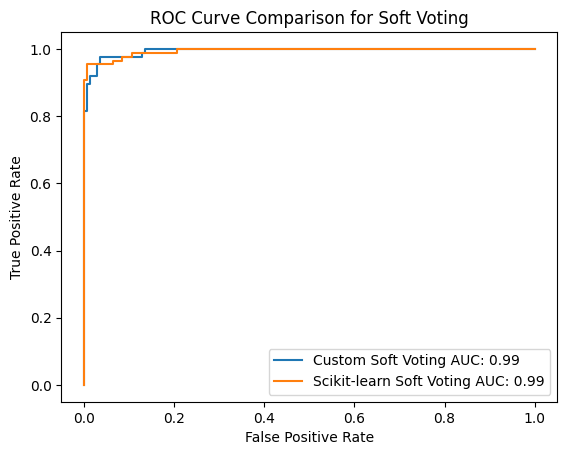

In [ ]:
# Map labels
label_mapping = {'B': 0, 'M': 1}
test_labels_binary = [label_mapping[label] for label in test_labels]

# Custom soft voting probabilities
custom_soft_probs = ensemble_soft.predict_proba(test_examples)[:, 1]

# Scikit-learn soft voting probabilities
sk_soft_probs = model_soft.predict_proba(test_examples)[:, 1]

# Compute ROC curve for custom soft voting
custom_fpr, custom_tpr, _ = roc_curve(test_labels_binary, custom_soft_probs)
custom_auc = auc(custom_fpr, custom_tpr)

# Compute ROC curve for Scikit-learn soft voting
sk_fpr, sk_tpr, _ = roc_curve(test_labels_binary, sk_soft_probs)
sk_auc = auc(sk_fpr, sk_tpr)

# Plot ROC curve comparison
plt.figure()
plt.plot(custom_fpr, custom_tpr, label=f"Custom Soft Voting AUC: {custom_auc:.2f}")
plt.plot(sk_fpr, sk_tpr, label=f"Scikit-learn Soft Voting AUC: {sk_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Soft Voting")
plt.legend()
plt.show()

### **Bagging Classifier Implementation For biopsies Dataset**

In [ ]:
# MY BAGGING IMPLEMENTATION
# Create bagging ensemble classifier using MyDecisionTreeClassifier
bagging_dt = myBaggingClassifier(base_model=dt, n_estimators=10, bootstrap=True, bootstrap_features=False)

# Call the model's fitting/training algorithm, passing in our training examples and training labels
bagging_dt.fit(train_examples, train_labels)
# Use the trained model to generate predictions based on our testing examples
bagging_dt_predictions = bagging_dt.predict(test_examples)

# Find the total number of model predictions that matched with their corresponding testing labels
correct_predictions = sum(predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy = correct_predictions / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (My Bagging Classifier)::", accuracy, "(or", round(accuracy*100, 1), "%)")



#SCIKIT-LEARNS'S IMPLEMENTATIONS
# set the details of the classifier we want to use (default hyperparameters)
model_dt = DecisionTreeClassifier()
# Create a bagging ensemble classifier componsed of 100 DTs
model_Bagging = BaggingClassifier(estimator=model_dt, n_estimators=100, random_state=99,
                                  bootstrap=True, bootstrap_features=False)

# Call the model's fitting/training algorithm, passing in our training examples and training labels
model_Bagging.fit(train_examples, train_labels)
# Use the trained model to generate predictions based on our testing examples
predictions = model_Bagging.predict(test_examples)

# Find the total number of model predictions that matched with their corresponding testing labels
correct_predictions = sum(predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy = correct_predictions / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (scikit-learn Bagging Classifier):", accuracy, "(or", round(accuracy*100, 1), "%)")

Accuracy (My Bagging Classifier):: 0.973568281938326 (or 97.4 %)
Accuracy (scikit-learn Bagging Classifier): 0.9559471365638766 (or 95.6 %)


#### **EVALUATION: Bagging Classifier Implementation For biopsies Dataset**

In [ ]:
# MY BAGGING IMPLEMENTATION
bagging_dt = myBaggingClassifier(base_model=dt, n_estimators=10, bootstrap=True, bootstrap_features=False)
bagging_dt.fit(train_examples, train_labels)
bagging_dt_predictions = bagging_dt.predict(test_examples)

# Accuracy
bagging_dt_accuracy = accuracy_score(test_labels, bagging_dt_predictions)
print("Accuracy (My Bagging Classifier):", bagging_dt_accuracy, "(or", round(bagging_dt_accuracy * 100, 1), "%)")

# Confusion Matrix
bagging_dt_cm = confusion_matrix(test_labels, bagging_dt_predictions)
print("Confusion Matrix (My Bagging Classifier):\n", bagging_dt_cm)

# Classification Report
print("Classification Report (My Bagging Classifier):\n", classification_report(test_labels, bagging_dt_predictions))


# SCIKIT-LEARN'S IMPLEMENTATION
model_dt = DecisionTreeClassifier()
model_Bagging = BaggingClassifier(estimator=model_dt, n_estimators=100, random_state=99,
                                  bootstrap=True, bootstrap_features=False)
model_Bagging.fit(train_examples, train_labels)
sk_bagging_predictions = model_Bagging.predict(test_examples)

# Accuracy
sk_bagging_accuracy = accuracy_score(test_labels, sk_bagging_predictions)
print("Accuracy (Scikit-learn Bagging Classifier):", sk_bagging_accuracy, "(or", round(sk_bagging_accuracy * 100, 1), "%)")

# Confusion Matrix
sk_bagging_cm = confusion_matrix(test_labels, sk_bagging_predictions)
print("Confusion Matrix (Scikit-learn Bagging Classifier):\n", sk_bagging_cm)

# Classification Report
print("Classification Report (Scikit-learn Bagging Classifier):\n", classification_report(test_labels, sk_bagging_predictions))

Accuracy (My Bagging Classifier): 0.9779735682819384 (or 97.8 %)
Confusion Matrix (My Bagging Classifier):
 [[136   4]
 [  1  86]]
Classification Report (My Bagging Classifier):
               precision    recall  f1-score   support

           B       0.99      0.97      0.98       140
           M       0.96      0.99      0.97        87

    accuracy                           0.98       227
   macro avg       0.97      0.98      0.98       227
weighted avg       0.98      0.98      0.98       227

Accuracy (Scikit-learn Bagging Classifier): 0.9559471365638766 (or 95.6 %)
Confusion Matrix (Scikit-learn Bagging Classifier):
 [[137   3]
 [  7  80]]
Classification Report (Scikit-learn Bagging Classifier):
               precision    recall  f1-score   support

           B       0.95      0.98      0.96       140
           M       0.96      0.92      0.94        87

    accuracy                           0.96       227
   macro avg       0.96      0.95      0.95       227
weighted avg 

### **Pasting Classifier Implementation For biopsies Dataset**

In [ ]:
# Pasting with NO replacement bootstrap=False, bootstrap_Feature=True
# Create a pasting ensemble classifier composed of 100 decision trees

# MY PASTING IMPLEMENTATION
# Create pasting ensemble classifier using MyDecisionTreeClassifier
pasting_dt = myBaggingClassifier(base_model=dt, n_estimators=10, bootstrap=False, bootstrap_features=True)

# Call the model's fitting/training algorithm, passing in our training examples and training labels
pasting_dt.fit(train_examples, train_labels)
# Use the trained model to generate predictions based on our testing examples
pasting_dt_predictions = pasting_dt.predict(test_examples)

# Find the total number of model predictions that matched with their corresponding testing labels
correct_predictions_pasting = sum(pasting_dt_predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy_pasting = correct_predictions_pasting / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Accuracy (My Pasting Classifier)::", accuracy_pasting, "(or", round(accuracy_pasting * 100, 1), "%)")




# SCikit-learn's Implementations
# Use bootstrap=False for pasting (sampling without replacement) and bootstrap_features=True
model_pasting = BaggingClassifier(estimator=model_dt, n_estimators=100, random_state=99,
                                  bootstrap=False, bootstrap_features=True)

# Call the model's fitting/training algorithm, passing in our training examples and training labels
model_pasting.fit(train_examples, train_labels)
# Use the trained model to generate predictions based on our testing examples
predictions_pasting = model_pasting.predict(test_examples)

# Find the total number of model predictions that matched with their corresponding testing labels
correct_predictions_pasting_sklearn = sum(predictions_pasting == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy_pasting_sklearn = correct_predictions_pasting_sklearn / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Pasting Accuracy (scikit-learn):", accuracy_pasting_sklearn, "(or", round(accuracy_pasting_sklearn * 100, 1), "%)")

Accuracy (My Pasting Classifier):: 0.9647577092511013 (or 96.5 %)
Pasting Accuracy (scikit-learn): 0.960352422907489 (or 96.0 %)


#### **EVALUATION: Pasting Classifier Implementation For biopsies Dataset**

Accuracy (My Pasting Classifier): 0.973568281938326 (or 97.4 %)

Confusion Matrix (My Pasting Classifier):
[[137   3]
 [  3  84]]

Classification Report (My Pasting Classifier):
              precision    recall  f1-score   support

           B       0.98      0.98      0.98       140
           M       0.97      0.97      0.97        87

    accuracy                           0.97       227
   macro avg       0.97      0.97      0.97       227
weighted avg       0.97      0.97      0.97       227


Accuracy (Scikit-learn Pasting): 0.960352422907489 (or 96.0 %)

Confusion Matrix (Scikit-learn Pasting):
[[137   3]
 [  6  81]]

Classification Report (Scikit-learn Pasting):
              precision    recall  f1-score   support

           B       0.96      0.98      0.97       140
           M       0.96      0.93      0.95        87

    accuracy                           0.96       227
   macro avg       0.96      0.95      0.96       227
weighted avg       0.96      0.96      0.96    

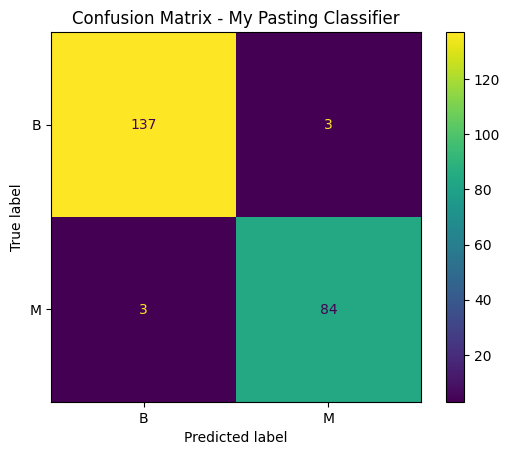

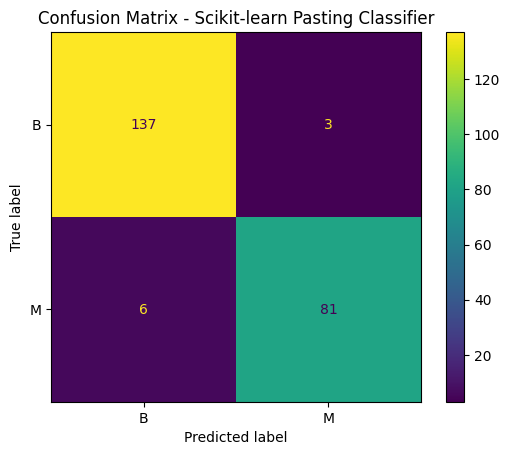

In [ ]:
# My Pasting Implementation
# Train and predict using your custom pasting implementation
pasting_dt.fit(train_examples, train_labels)
pasting_dt_predictions = pasting_dt.predict(test_examples)

# Calculate accuracy
accuracy_pasting = accuracy_score(test_labels, pasting_dt_predictions)
print("Accuracy (My Pasting Classifier):", accuracy_pasting, "(or", round(accuracy_pasting * 100, 1), "%)")

# Confusion Matrix for custom implementation
confusion_pasting = confusion_matrix(test_labels, pasting_dt_predictions)
print("\nConfusion Matrix (My Pasting Classifier):")
print(confusion_pasting)

# Classification Report for custom implementation
report_pasting = classification_report(test_labels, pasting_dt_predictions)
print("\nClassification Report (My Pasting Classifier):")
print(report_pasting)

# --- Scikit-learn Pasting Implementation ---
# Train and predict using scikit-learn's BaggingClassifier
model_pasting.fit(train_examples, train_labels)
predictions_pasting = model_pasting.predict(test_examples)

# Calculate accuracy
accuracy_pasting_sklearn = accuracy_score(test_labels, predictions_pasting)
print("\nAccuracy (Scikit-learn Pasting):", accuracy_pasting_sklearn, "(or", round(accuracy_pasting_sklearn * 100, 1), "%)")

# Confusion Matrix for scikit-learn implementation
confusion_pasting_sklearn = confusion_matrix(test_labels, predictions_pasting)
print("\nConfusion Matrix (Scikit-learn Pasting):")
print(confusion_pasting_sklearn)

# Classification Report for scikit-learn implementation
report_pasting_sklearn = classification_report(test_labels, predictions_pasting)
print("\nClassification Report (Scikit-learn Pasting):")
print(report_pasting_sklearn)

# --- Comparison ---
print("\nComparison Summary:")
print(f"My Pasting Classifier Accuracy: {accuracy_pasting:.2f}")
print(f"Scikit-learn Pasting Accuracy: {accuracy_pasting_sklearn:.2f}")

# Custom implementation confusion matrix
disp_my_pasting = ConfusionMatrixDisplay(confusion_matrix=confusion_pasting, display_labels=np.unique(test_labels))
disp_my_pasting.plot()
plt.title("Confusion Matrix - My Pasting Classifier")

# Scikit-learn implementation confusion matrix
disp_sklearn_pasting = ConfusionMatrixDisplay(confusion_matrix=confusion_pasting_sklearn, display_labels=np.unique(test_labels))
disp_sklearn_pasting.plot()
plt.title("Confusion Matrix - Scikit-learn Pasting Classifier")

plt.show()


### **Random Subspaces Implementation For biopsies Dataset**

In [ ]:
# My Implementation
# Instantiate and train the Random Subspaces ensemble using myBaggingClassifier
dt = MyDecisionTreeClassifier(max_depth=10)  # Example: Set max depth
random_subspaces_classifier = myBaggingClassifier(base_model=dt, n_estimators=10, bootstrap=False, bootstrap_features=True)

# Fit the model using training data
random_subspaces_classifier.fit(np.array(train_examples), np.array(train_labels))
# Generate predictions for test data
random_subspaces_predictions = random_subspaces_classifier.predict(np.array(test_examples))

#### **EVALUATION: Random Subspaces**

In [ ]:
# Evaluate the accuracy
accuracy_random_subspaces = accuracy_score(test_labels, random_subspaces_predictions)
print("Accuracy (My Random Subspaces with Bagging Classifier):", accuracy_random_subspaces, "(or", round(accuracy_random_subspaces * 100, 1), "%)")

# Confusion Matrix
confusion_random_subspaces = confusion_matrix(test_labels, random_subspaces_predictions)
print("\nConfusion Matrix (My Random Subspaces with Bagging Classifier):")
print(confusion_random_subspaces)

# Classification Report
report_random_subspaces = classification_report(test_labels, random_subspaces_predictions)
print("\nClassification Report (My Random Subspaces with Bagging Classifier):")
print(report_random_subspaces)

# Comparison to scikit-learn's Random Subspaces implementation
print("\nComparison Summary:")
print(f"My Random Subspaces Accuracy: {accuracy_random_subspaces:.2f}")






# SCikit-learn's Implementations
# set the details of the classifier we want to use (default hyperparameters)
model_dt = DecisionTreeClassifier(random_state=99)
# Create a random subspaces ensemble classifier composed of 100 DTs
model = BaggingClassifier(model_dt, n_estimators=100, random_state=99, bootstrap=False, max_features=6)

# Call the model's fitting/training algorithm, passing in our training examples and training labels
model.fit(train_examples, train_labels)
# Use the trained model to generate predictions based on our testing examples
predictions = model.predict(test_examples)

# Find the total number of model predictions that matched with their corresponding testing labels
correct_predictions = sum(predictions == test_labels)
# Calculate the model's accuracy: the fraction of predictions that were correct
accuracy = correct_predictions / len(test_labels)
# Display the accuracy as a single quantitative measure of overall performance
print("Scikit-learn Random Subspaces Accuracy:", accuracy, "(or", round(accuracy*100, 1), "%)")

Accuracy (My Random Subspaces with Bagging Classifier): 0.9647577092511013 (or 96.5 %)

Confusion Matrix (My Random Subspaces with Bagging Classifier):
[[138   2]
 [  6  81]]

Classification Report (My Random Subspaces with Bagging Classifier):
              precision    recall  f1-score   support

           B       0.96      0.99      0.97       140
           M       0.98      0.93      0.95        87

    accuracy                           0.96       227
   macro avg       0.97      0.96      0.96       227
weighted avg       0.97      0.96      0.96       227


Comparison Summary:
My Random Subspaces Accuracy: 0.96
Scikit-learn Random Subspaces Accuracy: 0.960352422907489 (or 96.0 %)


### **Random Forest Implementation For biopsies Dataset**

In [ ]:
# Preprocessing: Encode string labels into numeric values for compatibility with classifiers
# as Random Forest expect numeric inputs for labels.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)  # Convert training labels to integers
test_labels = label_encoder.transform(test_labels)        # Convert test labels to the same integer

# Initialise the custom Random Forest model with specific hyperparameters (estimators=10, maximum depth of 5) to prevent overfitting
my_rf_model = MyRandomForestClassifier(n_trees=10, max_depth=5, min_samples_split=2)

# Fit the custom Random Forest model on the training data
# This step trains the ensemble of decision trees using bagging and bootstrapped data subsets.
my_rf_model.fit(train_examples, train_labels)
# Predict the labels of the test examples using the trained custom Random Forest model
# aggregate predictions from all trees in the forest to get the final classification result.
my_rf_predictions = my_rf_model.predict(test_examples)





# Initialize Scikit-learn's Random Forest model with equivalent hyperparameters
sklearn_rf_model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=99)

# Fit & Predict Scikit-learn's Random Forest model on the training data
sklearn_rf_model.fit(train_examples, train_labels)
sklearn_rf_predictions = sklearn_rf_model.predict(test_examples)

#### **EVALUATION: Random Forest**

My Random Forest Accuracy: 0.960352422907489
My Random Forest Confusion Matrix:
 [[135   5]
 [  4  83]]


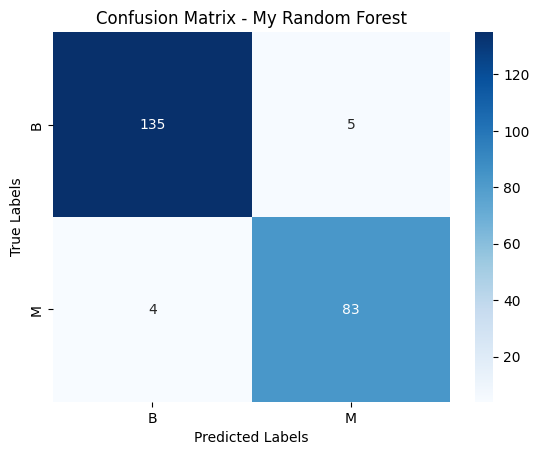


Scikit-learn Random Forest Accuracy: 0.9647577092511013
Scikit-learn Random Forest Confusion Matrix:
 [[137   3]
 [  5  82]]


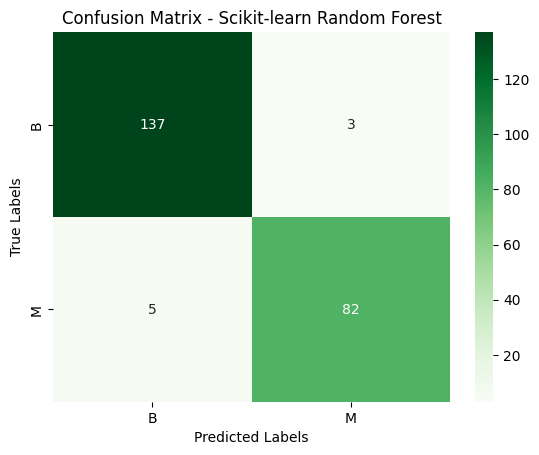


 Accuracy Comparison:  My Random Forest VS Scikit-learn Random Forest


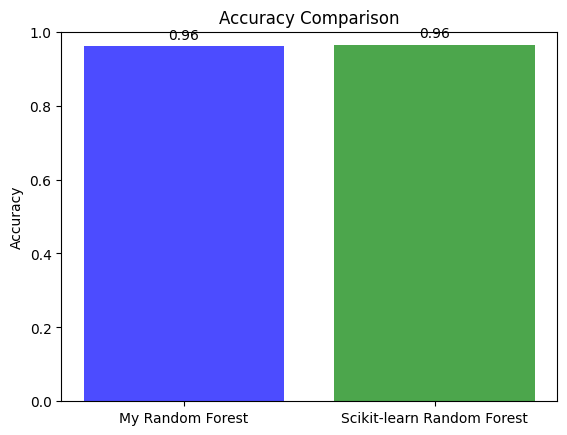

In [ ]:
# Evaluate the performance of the custom Random Forest model using accuracy and confusion matrix

# Accuracy measures the overall correctness of the predictions, and the confusion matrix shows detailed classification results.
my_rf_accuracy = accuracy_score(test_labels, my_rf_predictions)
my_rf_confusion_matrix = confusion_matrix(test_labels, my_rf_predictions)

# This shows how well the custom implementation performed on the test set.
print("My Random Forest Accuracy:", my_rf_accuracy)
print("My Random Forest Confusion Matrix:\n", my_rf_confusion_matrix)

# Plot the confusion matrix for the My Random Forest model
plt.figure()
sns.heatmap(my_rf_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - My Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()




# Evaluate the performance of Scikit-learn's Random Forest model

# These metrics allow us to directly compare the two implementations.
sklearn_rf_accuracy = accuracy_score(test_labels, sklearn_rf_predictions)
sklearn_rf_cm = confusion_matrix(test_labels, sklearn_rf_predictions)

# Print the accuracy and confusion matrix for Scikit-learn's Random Forest model
# These results act as a baseline to verify the correctness of our custom model.
print("\nScikit-learn Random Forest Accuracy:", sklearn_rf_accuracy)
print("Scikit-learn Random Forest Confusion Matrix:\n", sklearn_rf_cm)

# Plot the confusion matrix for Scikit-learn's Random Forest model
plt.figure()
sns.heatmap(sklearn_rf_cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Scikit-learn Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()




# Compare My Random Forest VS Scikit-learn Random Forest
# Plot the accuracy comparison as a bar chart
print("\n Accuracy Comparison: ","My Random Forest VS Scikit-learn Random Forest")
plt.figure()
accuracy_values = [my_rf_accuracy, sklearn_rf_accuracy]
model_labels = ["My Random Forest", "Scikit-learn Random Forest"]
colors = ['blue', 'green']
plt.bar(model_labels, accuracy_values, color=colors, alpha=0.7)
plt.ylim(0, 1)
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
for i, v in enumerate(accuracy_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()




*   Confusion metrix for both my implementation and SK-Learn for all models (iris/biopsies)
*   Plot K value for all KNN implementation


*   Generalasation Visualazation for all models in (moon)






# Submission

Once you're ready to submit, you need to compress the whole of your 1CWK50-ML folder as a .zip file (no other compression formats), and upload it to Moodle. There are several ways to do this, but the instructions below offer a simple step-by-step guide:

*    **Make sure the output from all your code cells is showing (you can select 'Runtime' -> 'Run all' if you need to)**
*    Save your notebook (select 'File' -> 'Save')
*    Find your /1CWK50-ML/ folder via the Google Drive web interface ([https://drive.google.com/](https://https://drive.google.com/))
*    Right-click on the /1CWK50-ML/ folder, and select 'Download'. This will cause the folder to be compressed into a .zip file and then downloaded to your local machine.
*    Upload the resulting .zip file to the 1CWK50 submission point on Moodle.

**We recommend testing these steps, and asking any questions you might have, well before the final deadline.**